# Code to filter and preprocess the genotype data and compute the principal components and genetic relatedness matrix prior to running the outcome GWAS association.

### Contains code at the bottom of the notebook for running the GWAS using GMMAT that was included with the initial publication submission. During revision, we switched to using SAIGE for the association to reduce false positives related to case-control number imbalance. The initial GWAS analysis based on GMMAT is kept in this notebook for completeness but see Run_GWAS_AllPhenotypes.ipynb for the actual association tested used in the manuscript. 

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
sys.path.append('../../code/gwas_analysis')
from gwas_plotting import manhattan, manhattan_fixwidth, qqplot
from gwas_utils import annotate_gwas_plink2
from IPython.display import display
import glob
from scipy.stats import chi2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
tmpdir = '../../data/tmp/'
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)

gwasdir = os.path.join(tmpdir, 'GWAS')
if not os.path.exists(gwasdir):
    os.mkdir(gwasdir)
    
basedata = os.path.join(gwasdir, 'data')
if not os.path.exists(basedata):
    os.mkdir(basedata)
    
imputeddata = os.path.join(basedata, 'imputed')
if not os.path.exists(imputeddata):
    os.mkdir(imputeddata)
    
rawdata = os.path.join(basedata, 'raw')
if not os.path.exists(rawdata):
    os.mkdir(rawdata)

resdir = os.path.join(gwasdir, 'outcome_H3covar_20230804')
if not os.path.exists(resdir):
    os.mkdir(resdir)

## Prepare Phenotypes

In [21]:
# each row is a genotyped sample, named by its IID. this table contains metadata we can use for phenotype definition
# and stratification
group_fn = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/OmniH3Merged_PrePost2016_AggregatedLASVPhenotypes_20210829.tsv'
groups = pd.read_csv(group_fn, sep='\t')

In [22]:
groups[['#IID', 'SEX', 'Epoch_Bin', 'Country', 'Age']].head()

,#IID,SEX,Epoch_Bin,Country,Age
0,WG0284565-DNA_A02_G-5231,2,1,1,38.0
1,WG0284565-DNA_A03_G-5686,2,1,1,10.0
2,WG0284565-DNA_A04_G-5690,1,1,1,16.0
3,WG0284565-DNA_A05_G-5135,2,1,1,49.0
4,WG0284565-DNA_A06_G-5045,2,1,1,24.0


In [6]:
# phenotype definition
main_phenotype_data = groups[['#IID', 'SEX', 'Epoch_Bin', 'Country', 'Age']] #what we care about in definition
main_phenotype_data['Full_Batch'] = groups['Batch']
main_phenotype_data['H3'] = groups['Batch'].replace({25:0, 26:0, 50:0, 1:1, 2:1}) #batch definition 
main_phenotype_data['Omni_25A'] = main_phenotype_data['Full_Batch'].replace({25:1, 1:0, 2:0, 26:0, 50:0})
main_phenotype_data['Omni_25B'] = main_phenotype_data['Full_Batch'].replace({25:0, 1:0, 2:0, 26:1, 50:0})
main_phenotype_data['Omni_25'] = main_phenotype_data['Full_Batch'].replace({25:1, 1:0, 2:0, 26:1, 50:0})
main_phenotype_data.head()

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,#IID,SEX,Epoch_Bin,Country,Age,Full_Batch,H3,Omni_25A,Omni_25B,Omni_25
0,WG0284565-DNA_A02_G-5231,2,1,1,38.0,1,1,0,0,0
1,WG0284565-DNA_A03_G-5686,2,1,1,10.0,1,1,0,0,0
2,WG0284565-DNA_A04_G-5690,1,1,1,16.0,1,1,0,0,0
3,WG0284565-DNA_A05_G-5135,2,1,1,49.0,1,1,0,0,0
4,WG0284565-DNA_A06_G-5045,2,1,1,24.0,1,1,0,0,0


### NG - includes duplicates to be filtered

In [7]:
# phenotype definition

p = 'MergeEpoch_NG_Died_vs_Survived' 

cases = ['Post2016_NG_LASV_ExactLVMatchqPCR2xPosOrSeqPos_Died', 'Pre2016_NG_LASV_qPCRorSeq+_Died'] 
#all the cases to be merged: Nigerians across batches who are determined to be positive by qPCR or sequencing
controls = ['Post2016_NG_LASV_ExactLVMatchqPCR2xPosOrSeqPos_DC', 'Pre2016_NG_LASV_qPCRorSeq+_DC']
# all the controls to be merged: Nigerians across batches serving as population controls, and qPCR- samples
main_phenotype_data[p] = -1 #null
for c in cases:
    main_phenotype_data.loc[groups.index[groups[c]], p] = 1 #1 for cases
for c in controls:
    main_phenotype_data.loc[groups.index[groups[c]], p] = 0 #1 for controls   
print(p)
print(main_phenotype_data[p].value_counts())

MergeEpoch_NG_Died_vs_Survived
-1    5169
 0     254
 1     132
Name: MergeEpoch_NG_Died_vs_Survived, dtype: int64


/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### SL - includes duplicates to be filtered

In [11]:
p = 'MergeEpoch_SL_Died_vs_Survived' 

cases = ['Post2016_SL_LASV_AgPos_Died', 'Pre2016_SL_LASV_AgORSeqPos_Died'] 
controls = ['Post2016_SL_LASV_AgPos_DC', 'Pre2016_SL_LASV_AgORSeqPos_DC']
# all the controls to be merged: SL across batches serving as population controls

main_phenotype_data[p] = -1 #null
for c in cases:
    main_phenotype_data.loc[groups.index[groups[c]], p] = 1 #1 for cases
for c in controls:
    main_phenotype_data.loc[groups.index[groups[c]], p] = 0 #1 for controls   
print(p)
print(main_phenotype_data[p].value_counts())

MergeEpoch_SL_Died_vs_Survived
-1    5413
 1      86
 0      56
Name: MergeEpoch_SL_Died_vs_Survived, dtype: int64


/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
phenofn = os.path.join(gwasdir, 'outcome_20220118_SL.tsv')
print(phenofn)
main_phenotype_data.to_csv(phenofn, sep='\t', index=False)

## Subset the raw data, run PCA, construct GRM for each phenotype

In [12]:
main_phenotype_data.head()

,#IID,SEX,Epoch_Bin,Country,Age,Full_Batch,H3,Omni_25A,Omni_25B,Omni_25,MergeEpoch_NG_Died_vs_Survived,MergeEpoch_SL_Died_vs_Survived
0,WG0284565-DNA_A02_G-5231,2,1,1,38.0,1,1,0,0,0,-1,-1
1,WG0284565-DNA_A03_G-5686,2,1,1,10.0,1,1,0,0,0,-1,-1
2,WG0284565-DNA_A04_G-5690,1,1,1,16.0,1,1,0,0,0,-1,-1
3,WG0284565-DNA_A05_G-5135,2,1,1,49.0,1,1,0,0,0,-1,-1
4,WG0284565-DNA_A06_G-5045,2,1,1,24.0,1,1,0,0,0,-1,-1


In [13]:
pd.crosstab(main_phenotype_data['Age'].isnull(), main_phenotype_data['MergeEpoch_NG_Died_vs_Survived'])

MergeEpoch_NG_Died_vs_Survived,-1,0,1
Age,,,
False,4885,243,131
True,284,11,1


In [14]:
pd.crosstab(main_phenotype_data['Age'].isnull(), main_phenotype_data['MergeEpoch_SL_Died_vs_Survived'])

MergeEpoch_SL_Died_vs_Survived,-1,0,1
Age,,,
False,5117,56,86
True,296,0,0


In [15]:
# phenotypes
phenotypes = ['MergeEpoch_NG_Died_vs_Survived',
             'MergeEpoch_SL_Died_vs_Survived']
phenotypes

['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived']

In [16]:
# define covariates to be used in GLMM
covarmap = {
            'MergeEpoch_NG_Died_vs_Survived':['SEX', 'PCs', 'H3'],
            'MergeEpoch_SL_Died_vs_Survived':['SEX', 'PCs', 'H3']
            }

In [ ]:
# specify the local directory where plink should look for input files
rawbase= '%s/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped' % rawdata
rawbase

In [18]:
# parameters to be used in plink processing
maf = '1e-2' # minor allele frequency: the frequency at which the second most common allele occurs in a given population
#variants present at a frequency below the stated cutoff are removed
mac = 25 # minor allele count cutoff
hwe = '1e-6' # Hardy-Weinberg equilibrium exact test p-value. variants that deviate enough to generate this low
#of a pval are excluded
geno = '5e-2'# variants with missing call rates exceeding the provided value
prune_maf = '5e-2'# only minor alleles occurring at at least this frequency are considered
prune_r2 = '5e-1' # pairs of variants with squared correlation greater than the threshold are noted, 
#and variants are greedily pruned from the window until no such pairs remain
relcutoff = '5e-2'# excludes one member of each pair of samples with observed genomic relatedness greater than the 
#given cutoff value

In [ ]:
print(resdir)
print(phenotypes)

In [22]:
praw_adats = []
run = False
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    if not os.path.exists(pdir): os.mkdir(pdir)
    pdir_rawdata = os.path.join(pdir, 'raw_data')
    if not os.path.exists(pdir_rawdata): os.mkdir(pdir_rawdata)
    pdir_pca = os.path.join(pdir, 'pca')
    if not os.path.exists(pdir_pca): os.mkdir(pdir_pca)
    pdir_rel = os.path.join(pdir, 'rel')
    if not os.path.exists(pdir_rel): os.mkdir(pdir_rel)
    
    outfn = os.path.join(pdir_rawdata, rawbase.split('/')[-1]+'.{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.mac_{mac}'.format(p=p, maf=maf, hwe=hwe, geno=geno, mac=mac))
    praw_adats.append(outfn)
    
    ## Output samples with the current phenotype value to keep for subsequent calculations ##
    sampfn = os.path.join(pdir, 'samples.txt')
    if run:
        pc_exclude_samples = ['WG0341166-DNA_E09_3523-LV-18', 'WG0341182-DNA_G10_0073-LV-18'] ## sample that was extreme outlier on PC1 and PC2
        ind = (main_phenotype_data[p]!=-1) & ~main_phenotype_data['#IID'].isin(pc_exclude_samples)
        samples = main_phenotype_data.loc[ind, '#IID']
        fam = pd.read_csv(rawbase+'.fam', sep='\t', header=None)
        fam.index = fam[1]
        samples = list(set(fam.index).intersection(samples))
        fam = fam.loc[samples, [0,1]]
        fam.to_csv(sampfn, sep='\t', index=False, header=False)

    ## Filter variants on MAF Geno and HWE, output plink2 fileset ##
    filt_cmd = 'plink2 --make-pgen --bfile {inv} --keep {samples} --keep-allele-order --maf {maf} --hwe {hwe} --geno {geno} --mac {mac} --out {out}'.format(inv=rawbase, samples=sampfn, out=outfn, maf=maf, hwe=hwe, geno=geno, mac=mac)
    print(filt_cmd)
    if run:
        !{filt_cmd}
    print('--------------------------\n\n\n\n\n\n\n')

    ## Output plink1 fileset from plink2 fileset ##
    bed_cmd = 'plink2 --make-bed --pfile {inv} --out {inv} --keep-allele-order'.format(inv=outfn)
    print(bed_cmd)
    if run:
        !{bed_cmd}
    print('--------------------------\n\n\n\n\n\n\n')

    '''
    ## Compute an LD pruned variant set with a given MAF ##
    prunefn = os.path.join(pdir_pca, 'prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    prune_cmd = 'plink2 --pfile {adat} --out {adatout} --indep-pairwise 1000kb 1 {prune_r2} --maf {prune_maf}'.format(adat=outfn, adatout=prunefn, prune_r2=prune_r2, prune_maf=prune_maf)
    print(prune_cmd)
    !{prune_cmd}
    print('--------------------------\n\n\n\n\n\n\n')
    '''
    
    ## Run PCA without the pruned variant set ##
    pcafn = os.path.join(pdir_pca, os.path.basename(outfn))
    #pca_cmd = 'plink2 --pfile {adat} --out {adatout} --pca 20 --extract {adatout}.prune.in'.format(adat=outfn, adatout=prunefn)
    pca_cmd = 'plink2 --pfile {adat} --out {adatout} --pca 20'.format(adat=outfn, adatout=pcafn)
    print(pca_cmd)
    if run:
        !{pca_cmd}
    print('--------------------------\n\n\n\n\n\n\n')

    ## Compute GRM with the pruned variant set ## 
    #relbase = os.path.join(pdir_rel, 'prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    relbase = os.path.join(pdir_rel, os.path.basename(outfn))
    #rel_cmd = 'plink2 --make-rel square --pfile {adat} --out {adatout} --extract {prune}.prune.in'.format(adat=outfn, adatout=relbase, prune=prunefn)
    rel_cmd = 'plink2 --make-rel square --pfile {adat} --out {adatout}'.format(adat=outfn, adatout=relbase)
    print(rel_cmd)
    if run:
        !{rel_cmd}
    print('--------------------------\n\n\n\n\n\n\n')

    if run:
        ## Output a text file of the GRM containing sample IDs as column and row labels ## 
        relid = pd.read_csv(relbase+'.rel.id', sep='\t').iloc[:,1]
        rel = pd.read_csv(relbase+'.rel', header=None, sep='\t')
        rel.index = relid
        rel.columns = relid
        rel.to_csv(relbase+'.rel.withids.tsv', sep='\t')

    ## Output a binary GRM file ## 
    #rel_cmd = 'plink2 --make-grm-bin --pfile {adat} --out {adatout} --extract {prune}.prune.in'.format(adat=outfn, adatout=relbase, prune=prunefn)
    rel_cmd = 'plink2 --make-grm-bin --pfile {adat} --out {adatout}'.format(adat=outfn, adatout=relbase)
    print(rel_cmd)
    if run:
        !{rel_cmd}    
    print('--------------------------\n\n\n\n\n\n\n')

    ## Output a set of unrelated samples (GRM value < a given threshold) ## 
    unrelatedsfn = os.path.join(pdir_rel, 'unrelated_individuals.rel_{relcutoff}.txt'.format(relcutoff=relcutoff))
    get_unrelateds_cmd = 'plink --rel-cutoff {relcutoff} --grm-bin {rel} --out {out}'.format(rel=relbase, out=unrelatedsfn, relcutoff=relcutoff)
    print(get_unrelateds_cmd)
    if run:
        !{get_unrelateds_cmd}
    print('--------------------------\n\n\n\n\n\n\n')

plink2 --make-pgen --bfile ../../data/tmp/GWAS/data/raw/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped --keep ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/samples.txt --keep-allele-order --maf 1e-2 --hwe 1e-6 --geno 5e-2 --mac 25 --out ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25
--------------------------







plink2 --make-bed --pfile ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25 --out ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars

## Calculate PCs from unrelated individuals and project the full sample set onto this PC space. 
This allows signals that are dominated by close relatives (e.g. tribe) to become more visible 

In [19]:
run = True

for (i,p) in enumerate(phenotypes):
    ## Filter variants on MAF Geno and HWE, output plink2 fileset ##
    pdir = os.path.join(resdir, p)
    pdir_rawdata = os.path.join(pdir, 'raw_data')
    pdir_pca = os.path.join(pdir, 'pca')
    pdir_rel = os.path.join(pdir, 'rel')    
    unrelatedsfn = os.path.join(pdir_rel, 'unrelated_individuals.rel_{relcutoff}.txt.grm.id'.format(relcutoff=relcutoff))
    outfn = praw_adats[i] + '.unrelated'
    filt_cmd = 'plink2 --make-pgen --bfile {inv} --keep {samples} --keep-allele-order --maf {maf} --hwe {hwe} --geno {geno} --mac {mac} --out {out}'.format(inv=praw_adats[i], samples=unrelatedsfn, out=outfn, maf=maf, hwe=hwe, geno=geno, mac=mac)
    print(filt_cmd)
    if run:
        !{filt_cmd}
    
    '''
    ## Compute an LD pruned variant set with a given MAF ##
    prunefn = os.path.join(pdir_pca, 'unrelated.prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    prune_cmd = 'plink2 --pfile {adat} --out {adatout} --indep-pairwise 1000kb 1 {prune_r2} --maf {prune_maf}'.format(adat=outfn, adatout=prunefn, prune_r2=prune_r2, prune_maf=prune_maf)
    print(prune_cmd)
    !{prune_cmd}
    '''

    ## Run PCA with the pruned variant set ##
    #pca_cmd = 'plink2 --pfile {adat} --out {adatout} --freq --pca 20 biallelic-var-wts --extract {adatout}.prune.in'.format(adat=outfn, adatout=prunefn)
    pcafn = os.path.join(pdir_pca, os.path.basename(outfn))
    pca_cmd = 'plink2 --pfile {adat} --out {adatout} --freq --pca 20 biallelic-var-wts'.format(adat=outfn, adatout=pcafn)
    print(pca_cmd)
    if run:
        !{pca_cmd}
    
    '''
    CODE FROM https://groups.google.com/g/plink2-users/c/W6DL5-hs_Q4?pli=1
    Step 1: Export allele frequencies and PCA variant weights from your reference dataset.  E.g.
      plink2 --bfile hapmap --freq --pca var-wts --out pca_hapmap

    Step 2: Use --score to compute the necessary dot products with the variant weights.  E.g.
      plink2 --bfile mydata --read-freq pca_hapmap.afreq --score pca_hapmap.eigenvec.var 2 3 header-read no-mean-imputation variance-normalize --score-col-nums 5-14 --out pca_proj_mydata
    '''
    
    full_fn = praw_adats[i]
    #projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated.prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated')
    #project_cmd = 'plink2 --bfile {full} --read-freq {adatout}.afreq --score {adatout}.eigenvec.var 2 3 header-read no-mean-imputation variance-normalize --score-col-nums 5-14 --out {proj}'.format(full=full_fn, adatout=prunefn, proj=projectfn)
    project_cmd = 'plink2 --bfile {full} --read-freq {adatout}.afreq --score {adatout}.eigenvec.var 2 3 header-read no-mean-imputation variance-normalize --score-col-nums 5-14 --out {proj}'.format(full=full_fn, adatout=pcafn, proj=projectfn)
    print(project_cmd)
    if run:
        !{project_cmd}
    
    ## Load projection results and rename columns
    if run:
        projection = pd.read_csv(projectfn + '.sscore', sep='\t')
        cols = ['PC1_AVG', 'PC2_AVG', 'PC3_AVG', 'PC4_AVG', 'PC5_AVG', 'PC6_AVG',
           'PC7_AVG', 'PC8_AVG', 'PC9_AVG', 'PC10_AVG']
        rename = {c:c.split('_')[0] for c in cols}
        projection = projection.rename(columns=rename)
        projection.index = projection['IID']

        ## Scale by 1/(sqrt(eigenval) / -2) to convert to same scale as the original PCs
        #unrelated_eigenval = pd.read_csv(prunefn + '.eigenval', sep='\t', header=None)
        unrelated_eigenval = pd.read_csv(pcafn + '.eigenval', sep='\t', header=None)
        scale_factor = 1/(np.sqrt(unrelated_eigenval[0])/-2)
        scale_factor.index = ['PC%d' % (i+1) for i in scale_factor.index]
        for c in scale_factor.index[:10]:
            projection[c] = projection[c]*scale_factor[c]
        
        ## Compare to the original PCs as a sanity check
        #unrelated_eigenvec = pd.read_csv(prunefn + '.eigenvec', sep='\t')
        unrelated_eigenvec = pd.read_csv(pcafn + '.eigenvec', sep='\t')

        unrelated_eigenvec.index = unrelated_eigenvec['IID']
        display(
            pd.concat([unrelated_eigenvec['PC1'],
                   projection.loc[unrelated_eigenvec.index, 'PC1']], axis=1).head()
        )

        display(
            pd.concat([unrelated_eigenvec['PC2'],
                   projection.loc[unrelated_eigenvec.index, 'PC2']], axis=1).head()
        )
    
        ## Output projected rescaled PCs
        projection.to_csv(projectfn + '.PCs.tsv', sep='\t', index=False)

plink2 --make-pgen --bfile ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25 --keep ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/rel/unrelated_individuals.rel_5e-2.txt.grm.id --keep-allele-order --maf 1e-2 --hwe 1e-6 --geno 5e-2 --mac 25 --out ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.unrelated
PLINK v2.00a3LM 64-bit Intel (1 Jul 2021)      www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.Fil

,PC1,PC1
IID,,
WG0284584-DNA_C11_ISTH-CASE-878/LV/14,-0.065692,-0.065667
WG0284584-DNA_H11_ISTH-CASE-971/LV/14,-0.013820,-0.013820
WG0341166-DNA_B01_1130-LV-17,-0.009514,-0.009511
WG0341166-DNA_C01_1034-LV-17,0.022166,0.022161
WG0341166-DNA_C09_1249-LV-17,0.046127,0.046117


,PC2,PC2
IID,,
WG0284584-DNA_C11_ISTH-CASE-878/LV/14,0.005068,0.005058
WG0284584-DNA_H11_ISTH-CASE-971/LV/14,0.015376,0.015360
WG0341166-DNA_B01_1130-LV-17,-0.029640,-0.029636
WG0341166-DNA_C01_1034-LV-17,-0.045166,-0.045160
WG0341166-DNA_C09_1249-LV-17,-0.017426,-0.017426


plink2 --make-pgen --bfile ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_SL_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25 --keep ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_SL_Died_vs_Survived/rel/unrelated_individuals.rel_5e-2.txt.grm.id --keep-allele-order --maf 1e-2 --hwe 1e-6 --geno 5e-2 --mac 25 --out ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_SL_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.unrelated
PLINK v2.00a3LM 64-bit Intel (1 Jul 2021)      www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_SL_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.Fil

,PC1,PC1
IID,,
WG0284565-DNA_A08_G-7030,-0.049101,-0.049080
WG0284565-DNA_A09_G-7022,-0.020698,-0.020693
WG0284565-DNA_B08_G-7260,-0.028496,-0.028483
WG0284565-DNA_B10_G-7140,-0.045333,-0.045316
WG0284565-DNA_E08_G-6835,-0.032891,-0.032877


,PC2,PC2
IID,,
WG0284565-DNA_A08_G-7030,-0.016736,-0.016743
WG0284565-DNA_A09_G-7022,-0.027354,-0.027355
WG0284565-DNA_B08_G-7260,-0.022482,-0.022483
WG0284565-DNA_B10_G-7140,-0.088836,-0.088833
WG0284565-DNA_E08_G-6835,0.045313,0.045301


Text(0, 0.5, 'Porjected PC10 score\nfor unrelateds')

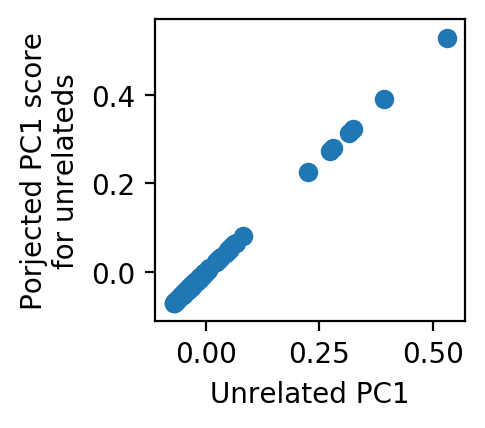

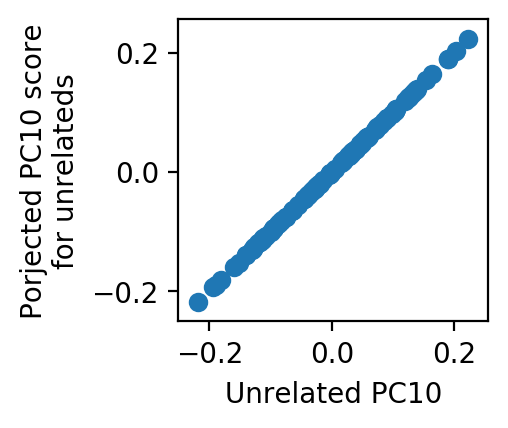

In [20]:
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200)
ax.scatter(unrelated_eigenvec['PC1'], projection.loc[unrelated_eigenvec.index, 'PC1'])
ax.set_xlabel('Unrelated PC1')
ax.set_ylabel('Porjected PC1 score\nfor unrelateds')
(fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=200)
ax.scatter(unrelated_eigenvec['PC10'], projection.loc[unrelated_eigenvec.index, 'PC10'])
ax.set_xlabel('Unrelated PC10')
ax.set_ylabel('Porjected PC10 score\nfor unrelateds')

## Plot the principal components stratified by case/control status for each phenotype

In [21]:
phenotypes

['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived']

In [18]:
# how many PCs to consider
# we are choosing 7 based on where the elbows occur on the the skree plots below
num_pcs = {'MergeEpoch_SL_Died_vs_Survived':4,
          'MergeEpoch_NG_Died_vs_Survived':6}

In [19]:
# phenotypes
phenotypes = ['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived']

In [20]:
# Dylan said this will let us edit in illustrator, we shall see!
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

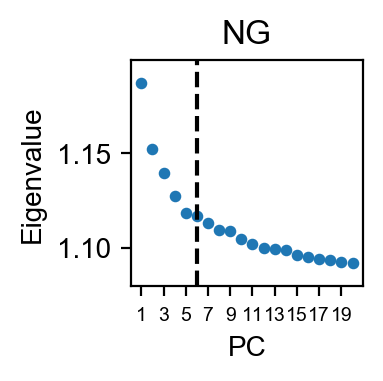

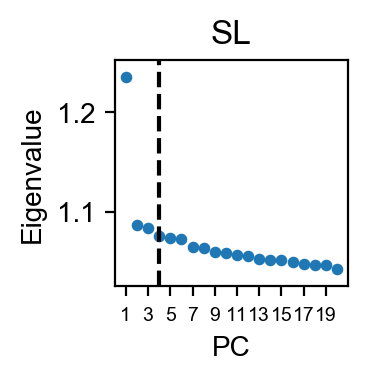

In [24]:
cmap = {0:'b', 1:'r'}
labmap = {0:'control', 1:'case'}
batchmap = {25:'r', 26:'b', 1:'g', 2:'g', 50:'y'}
for (i,p) in enumerate(phenotypes):
    ## Filter variants on MAF Geno and HWE, output plink2 fileset ##
    pdir = os.path.join(resdir, p)
    pdir_pca = os.path.join(pdir, 'pca')
    #prunefn = os.path.join(pdir_pca, 'unrelated.prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    outfn = praw_adats[i] + '.unrelated'
    pcafn = os.path.join(pdir_pca, os.path.basename(outfn))
    
    eigfn = pcafn + '.eigenval'
    eigenvals = pd.read_csv(eigfn, header=None)[0]
    
    (fig,ax) = plt.subplots(1,1, figsize=(1.5,1.5), dpi=200)
    ax.scatter(np.arange(1,len(eigenvals)+1), eigenvals, s=10)
    ax.set_xlabel('PC')
    ax.set_ylabel('Eigenvalue')
    ax.set_xticks(np.arange(1,21, step = 2))
    ax.set_xticklabels(np.arange(1,21, step = 2), fontsize=7)

    #ax.set_title(p)
    ylim = ax.get_ylim()
    ax.vlines(x=num_pcs[p], ymin=ylim[0], ymax=ylim[1], linestyle='--')
    ax.set_ylim(ylim)    
    ax.set_title(p.split('_')[1])
    plt.savefig('../../figures/PCA_Outcome_UnrelatedProjection_Skree_%s.pdf' % p.split('_')[1], bbox_inches='tight')
    plt.savefig('../../figures/PCA_Outcome_UnrelatedProjection_Skree_%s.png' % p.split('_')[1], bbox_inches='tight')

(303, 20)
(108, 20)


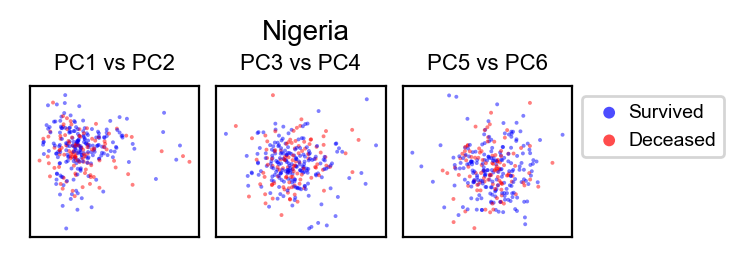

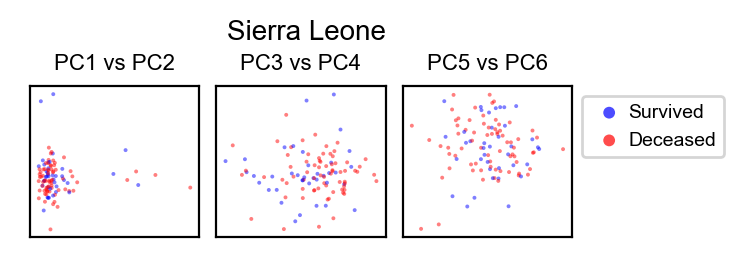

In [26]:
cmap = {0:'b', 1:'r'}
labmap = {0:'Survived', 1:'Deceased'}
batchmap = {25:'r', 26:'b', 1:'g', 2:'g', 50:'y'}
fullmap = {'NG':'Nigeria', 'SL':'Sierra Leone'}
for (i,p) in enumerate(phenotypes):
    ## Filter variants on MAF Geno and HWE, output plink2 fileset ##
    pdir = os.path.join(resdir, p)
    pdir_pca = os.path.join(pdir, 'pca')
    #prunefn = os.path.join(pdir_pca, 'unrelated.prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated.PCs.tsv'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    pcs = pd.read_csv(projectfn, sep='\t')
    
    pcs_merged = pd.merge(left=pcs, right=main_phenotype_data[['#IID', p, 'H3', 'Full_Batch']], left_on='IID', right_on='#IID', how='left')
    pcs_merged['color'] = pcs_merged[p].replace(cmap)
    print(pcs_merged.shape)

    (fig,axes) = plt.subplots(1,3, figsize=(3.5,1), dpi=200, gridspec_kw={'wspace':.1})
    axes = axes.ravel()
    for (num,firstpc) in enumerate(range(1,7, 2)):
        pc1 = 'PC%d' % firstpc
        pc2 = 'PC%d' % (firstpc+1)   
        
        for (k,g) in pcs_merged.groupby(p):
            axes[num].scatter([], [], color=cmap[k], 
                                  s=8, edgecolor='None', alpha=.7, label=labmap[k])                                 

        order = np.random.permutation(pcs_merged.shape[0])
        Z = pcs_merged.iloc[order, :]
        #Z = pcs_merged.sort_values(by=p, ascending=True)
        axes[num].scatter(Z.loc[:,pc1], Z.loc[:,pc2],
                          c=Z['color'], s=2, edgecolor='None', alpha=.5)     
            
            
        xlim = axes[num].get_xlim()
        ylim = axes[num].get_ylim()
        xpos = [xlim[0] + (xlim[1]-xlim[0]) * .25, xlim[0] + (xlim[1]-xlim[0]) * .75]
        ypos = [ylim[0] + (ylim[1]-ylim[0]) * .25, ylim[0] + (ylim[1]-ylim[0]) * .75]

        axes[num].set_xticks([])
        axes[num].set_yticks([]) 
        #axes[num].set_xticks(xpos)
        #axes[num].set_yticks(ypos)        
        #axes[num].set_xticklabels(['%.1f' % x for x in xpos], fontsize=6)        
        #axes[num].set_yticklabels(['%.1f' % x for x in ypos], fontsize=6)                
        #axes[num].set_xlabel(pc1, fontsize=7, labelpad=-.5)
        #axes[num].set_ylabel(pc2, fontsize=7, labelpad=-.5)
        axes[num].set_title('%s vs %s' % (pc1, pc2), fontsize=8) 

    axes[2].legend(bbox_to_anchor=(1,1), fontsize=7, markerscale=1.5, handletextpad=0)
    plt.figtext(.52, 1.15, fullmap[p.split('_')[1]], va='center', ha='center')
    plt.savefig('../../figures/PCA_Outcome_UnrelatedProjection_%s.pdf' % p.split('_')[1], bbox_inches='tight')
    plt.savefig('../../figures/PCA_Outcome_UnrelatedProjection_%s.png' % p.split('_')[1], bbox_inches='tight')

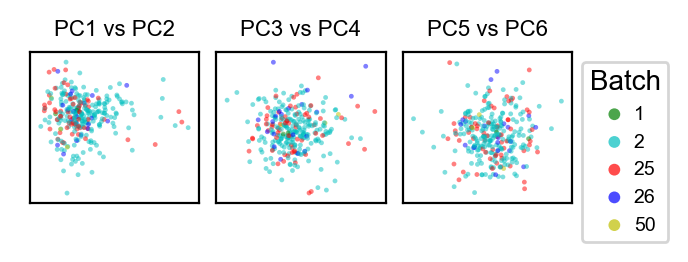

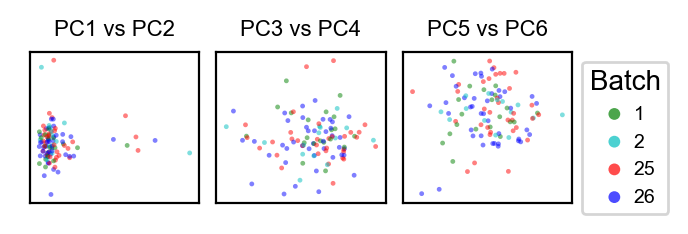

In [27]:
cmap = {0:'b', 1:'r'}
labmap = {0:'control', 1:'case'}
batchmap = {25:'r', 26:'b', 1:'g', 2:'c', 50:'y'}
fullmap = {'NG':'Nigeria', 'SL':'Sierra Leone'}
for (i,p) in enumerate(phenotypes):
    ## Filter variants on MAF Geno and HWE, output plink2 fileset ##
    pdir = os.path.join(resdir, p)
    pdir_pca = os.path.join(pdir, 'pca')
    #prunefn = os.path.join(pdir_pca, 'unrelated.prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated.PCs.tsv'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    pcs = pd.read_csv(projectfn, sep='\t')
    
    pcs_merged = pd.merge(left=pcs, right=main_phenotype_data[['#IID', p, 'H3', 'Full_Batch']], left_on='IID', right_on='#IID', how='left')
    pcs_merged['color'] = pcs_merged[p].replace(cmap)

    (fig,axes) = plt.subplots(1,3, figsize=(3.5,1), dpi=200, gridspec_kw={'wspace':.1})
    axes = axes.ravel()
    for (num,firstpc) in enumerate(range(1,7, 2)):
        pc1 = 'PC%d' % firstpc
        pc2 = 'PC%d' % (firstpc+1)   
        
        for (k,g) in pcs_merged.groupby('Full_Batch'):
            axes[num].scatter([], [], color=batchmap[k], 
                                  s=8, edgecolor='None', alpha=.7, label=k)                                 

        order = np.random.permutation(pcs_merged.shape[0])
        Z = pcs_merged.iloc[order, :]
        #Z = pcs_merged.sort_values(by=p, ascending=False)
        Z['color'] = Z['Full_Batch'].replace(batchmap)
        axes[num].scatter(Z.loc[:,pc1], Z.loc[:,pc2],
                          c=Z['color'], s=3, edgecolor='None', alpha=.5)     
            
            
        xlim = axes[num].get_xlim()
        ylim = axes[num].get_ylim()
        xpos = [xlim[0] + (xlim[1]-xlim[0]) * .25, xlim[0] + (xlim[1]-xlim[0]) * .75]
        ypos = [ylim[0] + (ylim[1]-ylim[0]) * .25, ylim[0] + (ylim[1]-ylim[0]) * .75]

        axes[num].set_xticks([])
        axes[num].set_yticks([]) 
        #axes[num].set_xticks(xpos)
        #axes[num].set_yticks(ypos)        
        #axes[num].set_xticklabels(['%.1f' % x for x in xpos], fontsize=6)        
        #axes[num].set_yticklabels(['%.1f' % x for x in ypos], fontsize=6)                
        #axes[num].set_xlabel(pc1, fontsize=7, labelpad=-.5)
        #axes[num].set_ylabel(pc2, fontsize=7, labelpad=-.5)
        axes[num].set_title('%s vs %s' % (pc1, pc2), fontsize=8) 

    axes[2].legend(bbox_to_anchor=(1,1), fontsize=7, markerscale=1.5, handletextpad=0, title='Batch')


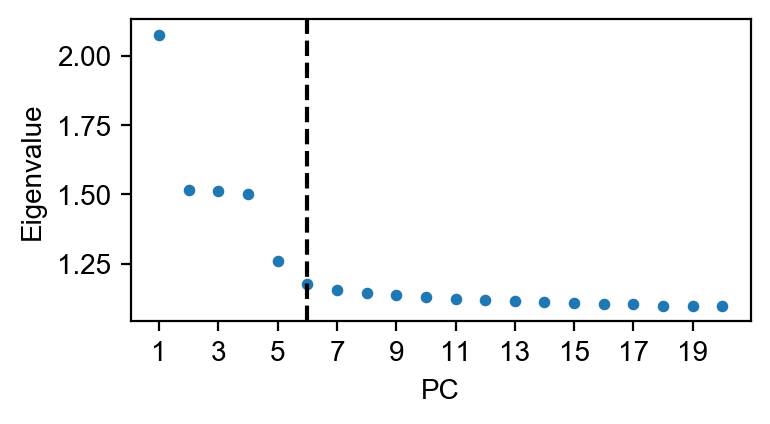

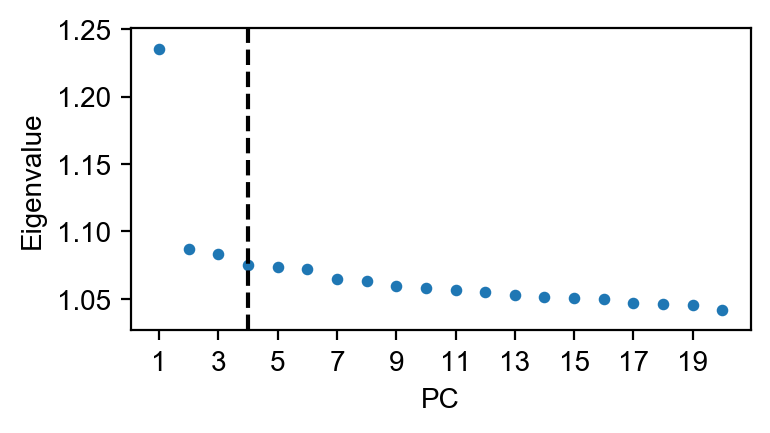

In [28]:
# update with
# 1. Manageable titles
for (i,p) in enumerate(phenotypes):
    pdir = os.path.join(resdir, p)
    pdir_pca = os.path.join(pdir, 'pca')
    eigfn = os.path.join(pdir_pca, os.path.basename(praw_adats[i]) + '.eigenval')
    #eigfn = os.path.join(pdir_pca, 'prune.ld_{prune_r2}.maf_{prune_maf}.eigenval'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    eigenvals = pd.read_csv(eigfn, header=None)[0]
    
    
    
    (fig,ax) = plt.subplots(1,1, figsize=(4,2), dpi=200)
    ax.scatter(np.arange(1,len(eigenvals)+1), eigenvals, s=10)
    ax.set_xlabel('PC')
    ax.set_ylabel('Eigenvalue')
    ax.set_xticks(np.arange(1,21, step = 2))
    #ax.set_title(p)
    ylim = ax.get_ylim()
    ax.vlines(x=num_pcs[p], ymin=ylim[0], ymax=ylim[1], linestyle='--')
    ax.set_ylim(ylim)
    #plt.savefig("/home/sraju/analysis_20200629/GWAS/20211007_full_gwas_figures/" + p + "_skree.png",
    #           bbox_inches = 'tight')

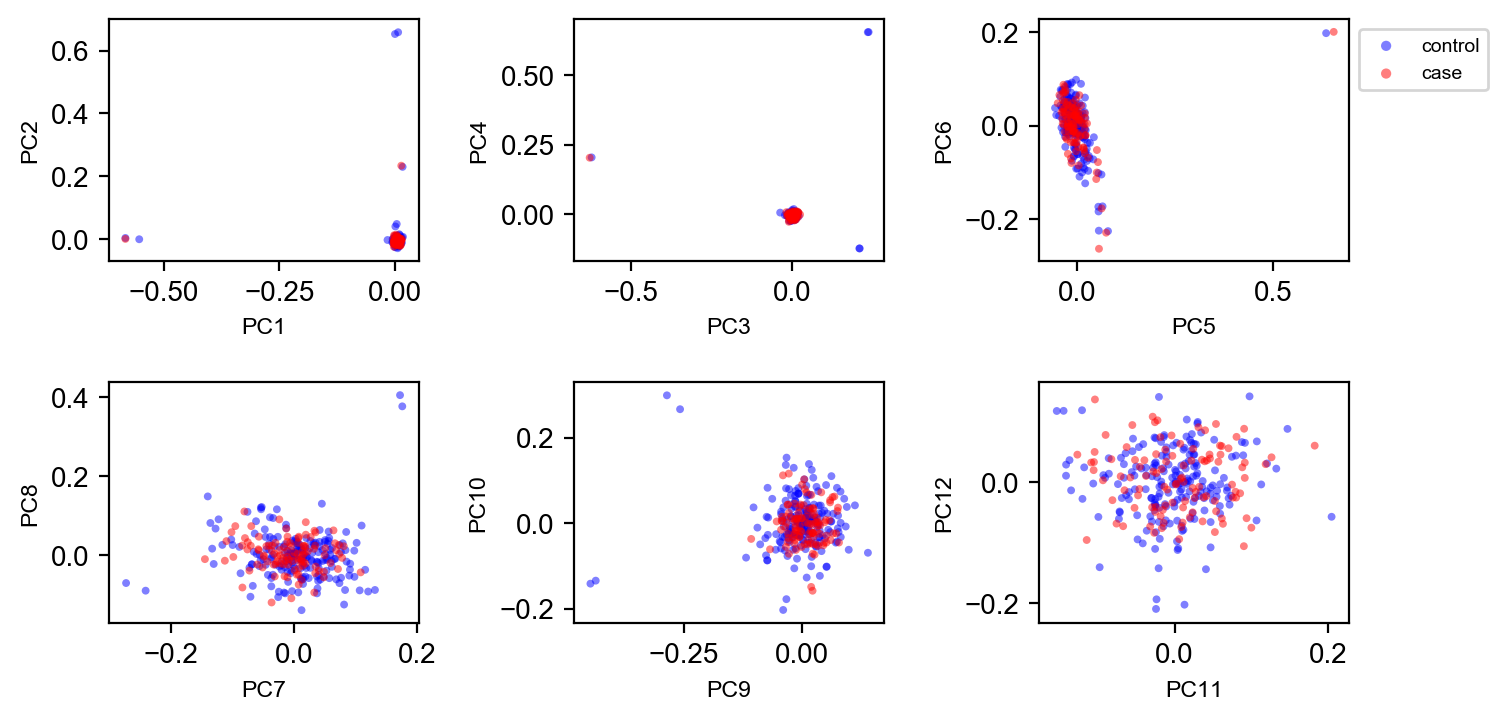

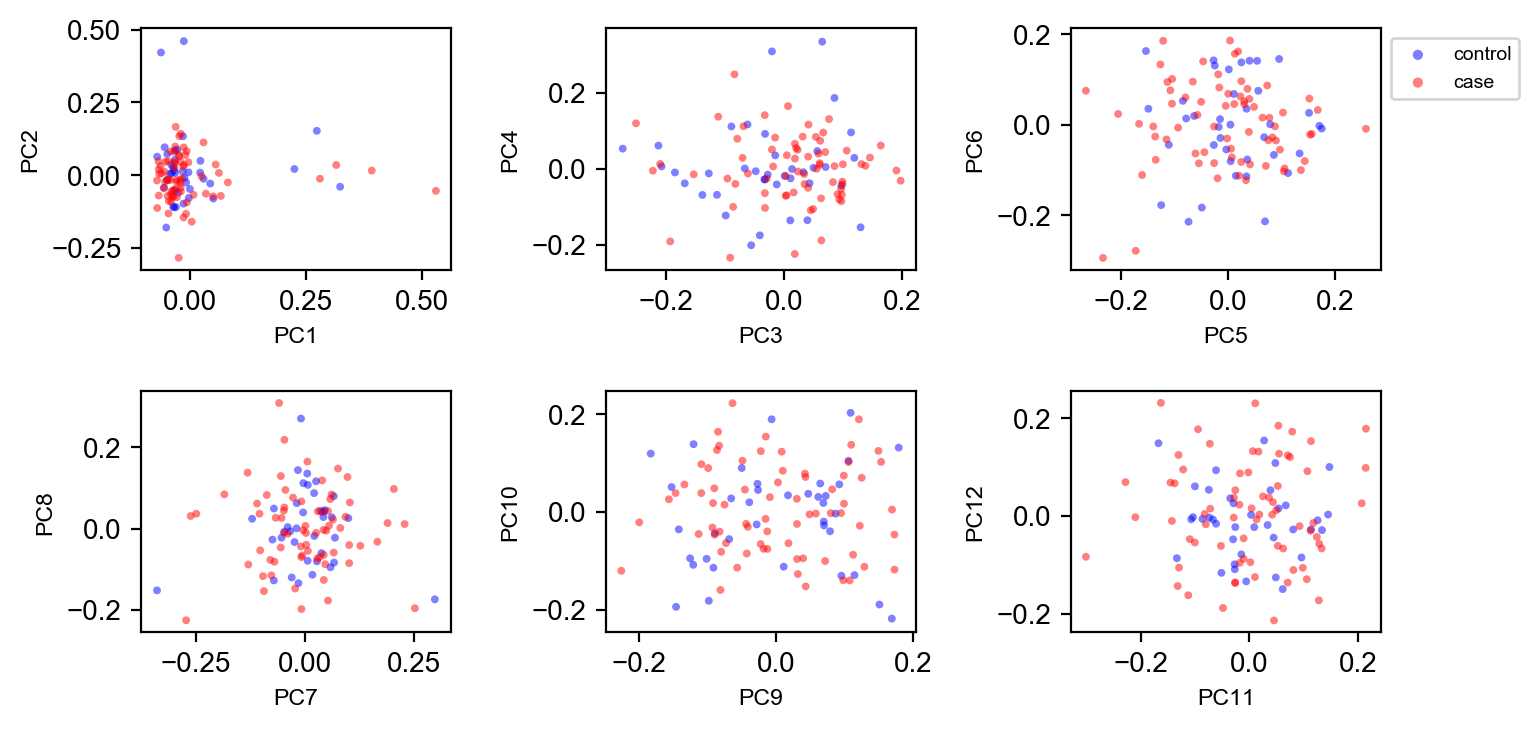

In [29]:
# the PCA plots show us internal relatedness structure. we do this to determine whether case/control status is
# confounded by family structure
# for instance, consider a scenario in which your case group contains a particular family with a set of specific 
#variants unrelated to disease
# you would find that these variants are overrepresented in the case group, and could erroneously conclude that this
# genomic region is associated with the case, when really it just arises due to family structure
# plotting the PCA and coloring by case/control status helps determine if this is the case

cmap = {0:'b', 1:'r'}
labmap = {0:'control', 1:'case'}
pcares = {}
for (i,p) in enumerate(phenotypes):
    pdir = os.path.join(resdir, p)
    pdir_pca = os.path.join(pdir, 'pca')
    #eigfn = os.path.join(pdir_pca, 'prune.ld_{prune_r2}.maf_{prune_maf}.eigenvec'.format(prune_r2=prune_r2, prune_maf=prune_maf))    
    eigfn = os.path.join(pdir_pca, os.path.basename(praw_adats[i]) + '.eigenvec')
    eigenvecs = pd.read_csv(eigfn, sep='\t')
    eigenvecs_merged = pd.merge(left=eigenvecs, right=main_phenotype_data[['#IID', p]], left_on='IID', right_on='#IID', how='left')
    (fig,axes) = plt.subplots(2,3, figsize=(8,4), dpi=200, gridspec_kw={'wspace':.5, 'hspace':.5})
    axes = axes.ravel()
    for (num,firstpc) in enumerate(range(1,13, 2)):
        pc1 = 'PC%d' % firstpc
        pc2 = 'PC%d' % (firstpc+1)
        
        for val in range(2):
            ind = eigenvecs_merged[p]==val
            axes[num].scatter(eigenvecs_merged.loc[ind,pc1], eigenvecs_merged.loc[ind,pc2],
                          color=cmap[val], label=labmap[val], s=8, edgecolor='None', alpha=.5)
        axes[num].set_xlabel(pc1, size = 'small')
        axes[num].set_ylabel(pc2, size = 'small')
        
    axes[2].legend(bbox_to_anchor=(1,1), fontsize=7, markerscale=1.3)
    pcares[p] = eigenvecs_merged
    #axes[1].set_title(p)
    #plt.savefig("/home/sraju/analysis_20200629/GWAS/20211007_full_gwas_figures/" + p + "_pcas.png",
    #          bbox_inches = 'tight')

## Double check no duplicates

In [31]:
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    pdir_rel = os.path.join(pdir, 'rel')
    #relbase = os.path.join(pdir_rel, 'prune.ld_{prune_r2}.maf_{prune_maf}'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    outfn = os.path.join(pdir_rawdata, rawbase.split('/')[-1]+'.{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.mac_{mac}'.format(p=p, maf=maf, hwe=hwe, geno=geno, mac=mac))
    relbase = os.path.join(pdir_rel, os.path.basename(outfn))

    rel = pd.read_csv(relbase+'.rel.withids.tsv', sep='\t', index_col=0)
    for i in rel.index:
        rel.at[i,i] = np.nan # nan at the diagonal because this is the same individual
        
    print(p)
    display(rel.max(axis=1).sort_values(ascending=False).head(20))

MergeEpoch_NG_Died_vs_Survived


IID
WG0341168-DNA_C02_0142-LV-18    0.588753
WG0341185-DNA_H01_0065-LV-18    0.588753
WG0341167-DNA_A03_1079-LV-18    0.499938
WG0341171-DNA_B08_0758-LV-18    0.499938
WG0341166-DNA_F01_1428-LV-17    0.495761
WG0341166-DNA_E03_1502-LV-17    0.495761
WG0341174-DNA_D03_0064-LV-18    0.495326
WG0341172-DNA_H04_1936-LV-18    0.492174
WG0341167-DNA_D11_0657-LV-18    0.492174
WG0341166-DNA_G11_1095-LV-17    0.228349
WG0341169-DNA_C05_1038-LV-17    0.228349
WG0341167-DNA_G07_0751-LV-18    0.104155
WG0341185-DNA_E01_0130-LV-18    0.104155
WG0341172-DNA_A08_0791-LV-18    0.099198
WG0341167-DNA_B03_1024-LV-18    0.099198
WG0341174-DNA_A07_1573-LV-18    0.064722
WG0341184-DNA_G07_0555-LV-17    0.064722
WG0341172-DNA_B12_0708-LV-18    0.047572
Fall2013_SM-4CDLK               0.047572
WG0341172-DNA_G03_0599-LV-17    0.027724
dtype: float64

MergeEpoch_SL_Died_vs_Survived


IID
Winter2013_SM-39SN9         0.044842
WG0341181-DNA_E01_S-106     0.044842
Winter2014_G2903-2.1        0.040274
WG0341181-DNA_C09_G-7530    0.040274
Winter2013_SM-39SNJ         0.034374
Winter2013_SM-39SNA         0.032646
Winter2014_G3157-2.1        0.028089
July2014SL_SM-5W5Q7         0.028089
WG0284570-DNA_D11_G-7820    0.025900
Winter2014_G2933.1          0.025900
Winter2013_SM-3NQA9         0.025329
Winter2013_SM-3MFLO         0.025329
Winter2013_SM-3NQ94         0.025075
Winter2014_G2944.1          0.024384
WG0284565-DNA_G11_G-7218    0.023680
Winter2014_G3283.1          0.013715
WG0284565-DNA_H11_G-7197    0.005576
WG0284587-DNA_D11_G-7702    0.004306
Winter2014_G2941.1          0.001423
Winter2014_G3339.1          0.001138
dtype: float64

## Prepare covariate files

In [32]:
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    pdir_rawdata = os.path.join(pdir, 'raw_data')
    pdir_pca = os.path.join(pdir, 'pca')
    nonpc_covars = [x for x in covarmap[p] if x != 'PCs']
    covar = main_phenotype_data[['#IID'] + [p] +nonpc_covars].copy()
    covar.index = covar['#IID']
    bedbase = os.path.join(pdir_rawdata, rawbase.split('/')[-1]+'.{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.mac_{mac}'.format(p=p, maf=maf, hwe=hwe, geno=geno, mac=mac))
    fam = pd.read_csv(bedbase+'.fam', sep='\t', header=None)
    covar = covar.loc[fam[1], :]
    covar = covar.rename(columns={'#IID':'IID'})
    
    if 'PCs' in covarmap[p]:    
        #eigfn = os.path.join(pdir_pca, 'prune.ld_{prune_r2}.maf_{prune_maf}.eigenvec'.format(prune_r2=prune_r2, prune_maf=prune_maf))    
        #eigenvecs = pd.read_csv(eigfn, sep='\t')
        projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated.PCs.tsv'.format(prune_r2=prune_r2, prune_maf=prune_maf))
        #projectfn = os.path.join(pdir_pca, 'FullSamplesSet.ProjectedOnUnrelated.prune.ld_{prune_r2}.maf_{prune_maf}.PCs.tsv'.format(prune_r2=prune_r2, prune_maf=prune_maf))
        eigenvecs = pd.read_csv(projectfn, sep='\t')
        eigenvecs.index = eigenvecs['IID']
        eigenvecs = eigenvecs[['PC%d' % x for x in range(1,(num_pcs[p]+1))]]
        covar = pd.merge(left=covar, right=eigenvecs, left_index=True, right_index=True)

    covar = covar.loc[fam[1], :]
    phenocovarfn = os.path.join(pdir, 'Covar_Pheno_UnrelatedPCs.txt')
    print(phenocovarfn)
    covar.to_csv(phenocovarfn, index=False, sep='\t')
    display(covar[p].value_counts())

../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/Covar_Pheno_UnrelatedPCs.txt


0    196
1    107
Name: MergeEpoch_NG_Died_vs_Survived, dtype: int64

../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_SL_Died_vs_Survived/Covar_Pheno_UnrelatedPCs.txt


1    70
0    38
Name: MergeEpoch_SL_Died_vs_Survived, dtype: int64

## Run GMMAT MLMA

In [34]:
# run the case/control logistic regression with only genotyped (unimputed) variants
ncores = 15
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    pdir_rawdata = os.path.join(pdir, 'raw_data')
    pdir_rel = os.path.join(pdir, 'rel')
    bedbase = os.path.join(pdir_rawdata, rawbase.split('/')[-1]+'.{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.mac_{mac}.bed'.format(p=p, maf=maf, hwe=hwe, geno=geno, mac=mac))
    phenofn = os.path.join(pdir, 'Covar_Pheno_UnrelatedPCs.txt')
    
    
    
    relfn = os.path.join(pdir_rel, os.path.basename(bedbase)[:-4] + '.rel.withids.tsv') 
    #relfn = os.path.join(pdir_rel, 'prune.ld_{prune_r2}.maf_{prune_maf}.rel.withids.tsv'.format(prune_r2=prune_r2, prune_maf=prune_maf))
    pcstr = ' + '.join(['PC%d' % x for x in range(1,(num_pcs[p]+1))])
    
    non_pc_covars = [x for x in covarmap[p] if x != 'PCs']
    
    formula = '{p} ~ {nonpcvars} + {pcvars}'.format(p=p, nonpcvars=' + '.join(non_pc_covars), pcvars=pcstr)
    formula = '"%s"' % formula
    covarstr = ''.join(covarmap[p])
    
    phenoresdir = os.path.join(pdir, 'results')
    if not os.path.exists(phenoresdir): os.mkdir(phenoresdir)
    rawgwasdir = os.path.join(phenoresdir, 'raw_gwas')
    if not os.path.exists(rawgwasdir): os.mkdir(rawgwasdir)

    nulloutfile = os.path.join(rawgwasdir, "gmmat.%s.%s.nullmodel.rds" % (covarstr, p))
    outfile = os.path.join(rawgwasdir, "gmmat.%s.%s.results.tsv" % (covarstr, p))
    cmd = 'Rscript --vanilla ../../code/gwas_analysis/run_GMMAT_fromPLINK.R %s %s %s %s %s %s %d' % (phenofn, bedbase, relfn, formula, nulloutfile, outfile, ncores)
    print(cmd)
    !{cmd}

Rscript --vanilla ../../code/gwas_analysis/run_GMMAT_fromPLINK.R ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/Covar_Pheno_UnrelatedPCs.txt ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.bed ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/rel/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.rel.withids.tsv "MergeEpoch_NG_Died_vs_Survived ~ SEX + H3 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6" ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/results/raw_gwas/gmmat.SEXPCsH3.MergeEpoch_NG_Died_vs_Survived.nullmodel.rds ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/results/raw_gwas/gmmat.SEXPCsH3.

In [35]:
resmap = {}
for p in phenotypes:
    covarstr = ''.join(covarmap[p])
    outfile = "{resdir}/{p}/results/raw_gwas/gmmat.{covarstr}.{p}.results.tsv".format(resdir=resdir, covarstr=covarstr, p=p)
    print(outfile)
    resmap[p] = outfile
    
res = {}
for p in phenotypes:
    res[p] = pd.read_csv(resmap[p], sep='\t')

../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/results/raw_gwas/gmmat.SEXPCsH3.MergeEpoch_NG_Died_vs_Survived.results.tsv
../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_SL_Died_vs_Survived/results/raw_gwas/gmmat.SEXPCsH3.MergeEpoch_SL_Died_vs_Survived.results.tsv


/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
res[p].head()

,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
0,1:752721:A:G,1,752721,G,A,108,0.000000,0.745370,0.936996,6.691155,0.717178
1,1:779322:A:G,1,779322,G,A,106,0.018519,0.528302,-8.606675,8.128524,0.002538
2,1:792480:C:T,1,792480,T,C,107,0.009259,0.126168,1.793200,4.193310,0.381199
3,1:797440:T:C,1,797440,C,T,106,0.018519,0.698113,-3.314780,6.970553,0.209293
4,1:798959:G:A,1,798959,A,G,108,0.000000,0.277778,-2.860684,6.757220,0.271119


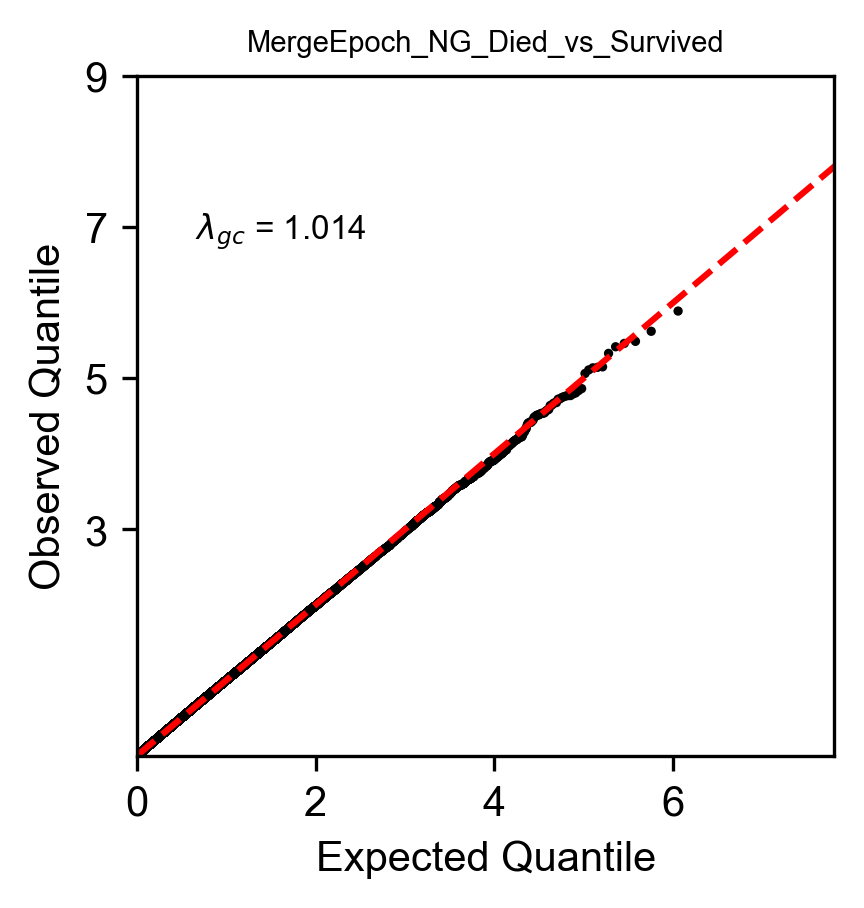

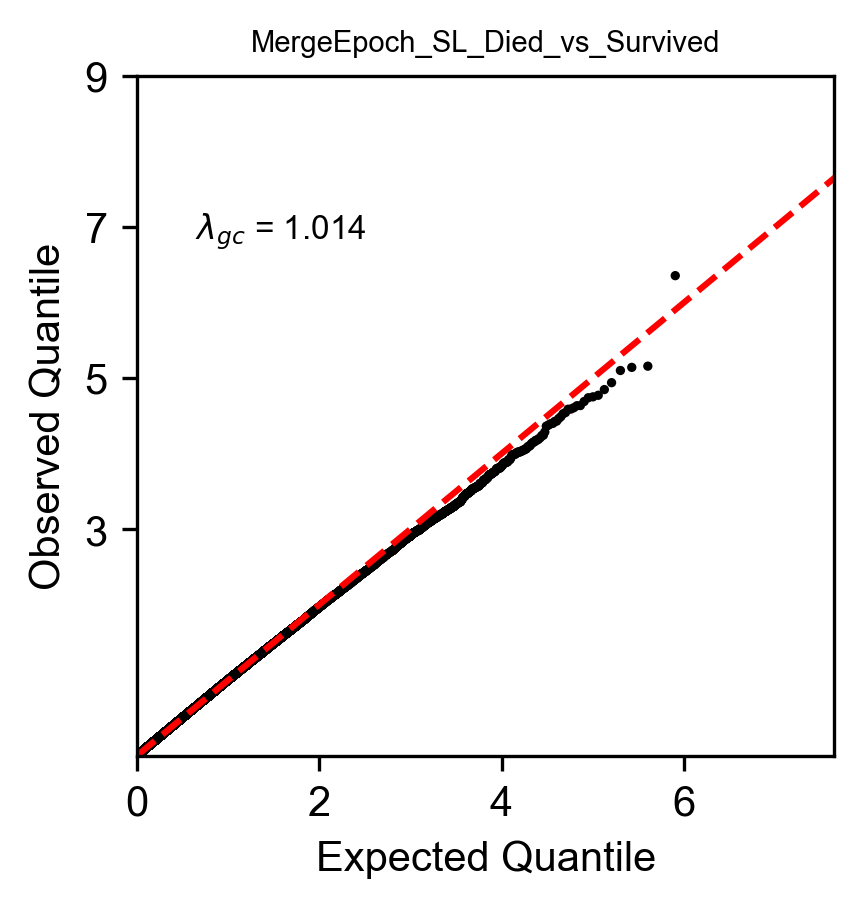

In [37]:
for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=300)
    ax = qqplot(res[p]['PVAL'].values.reshape(-1),
       fill_dens=0.2, 
       title=p, ax=ax)
    ax.set_yticks([3,5,7,9])
    ax.set_title(p, fontsize=7)
    gc = np.median(chi2.ppf(1-res[p]['PVAL'].dropna(), df=1)) / chi2.ppf(.5, df=1)
    plt.figtext(.19, .7, '$\lambda_{gc}$ = %.3f' % gc, fontsize=8)

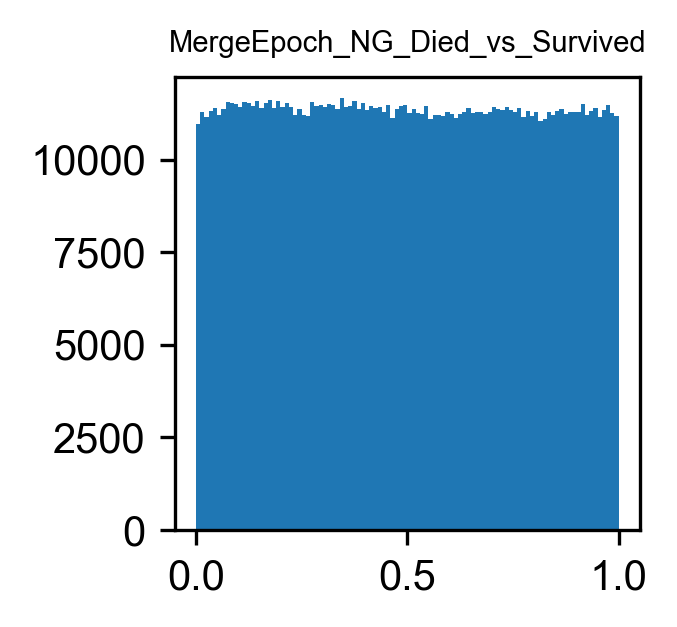

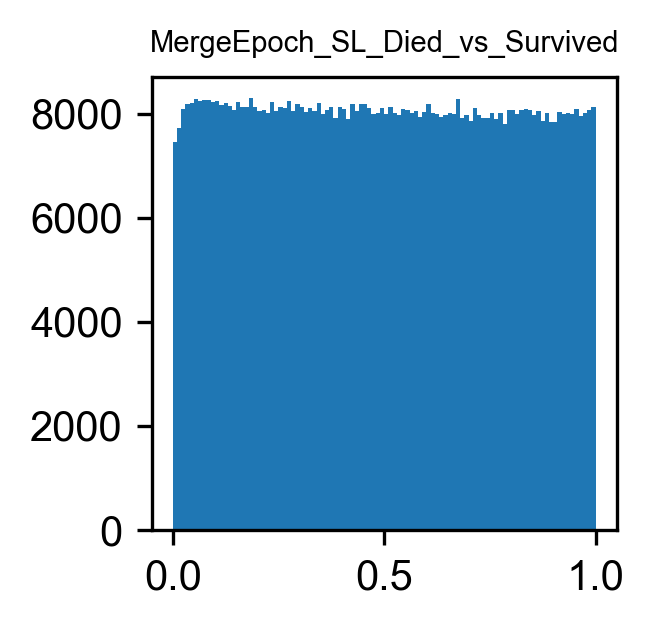

In [38]:
for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=300)
    _ = ax.hist(res[p]['PVAL'], bins=100)
    _ = ax.set_title(p, fontsize=7)
    #plt.savefig("/home/sraju/analysis_20200629/GWAS/20211007_full_gwas_figures/" + p + "_pvalhist_raw.png",
    #           bbox_inches = 'tight')

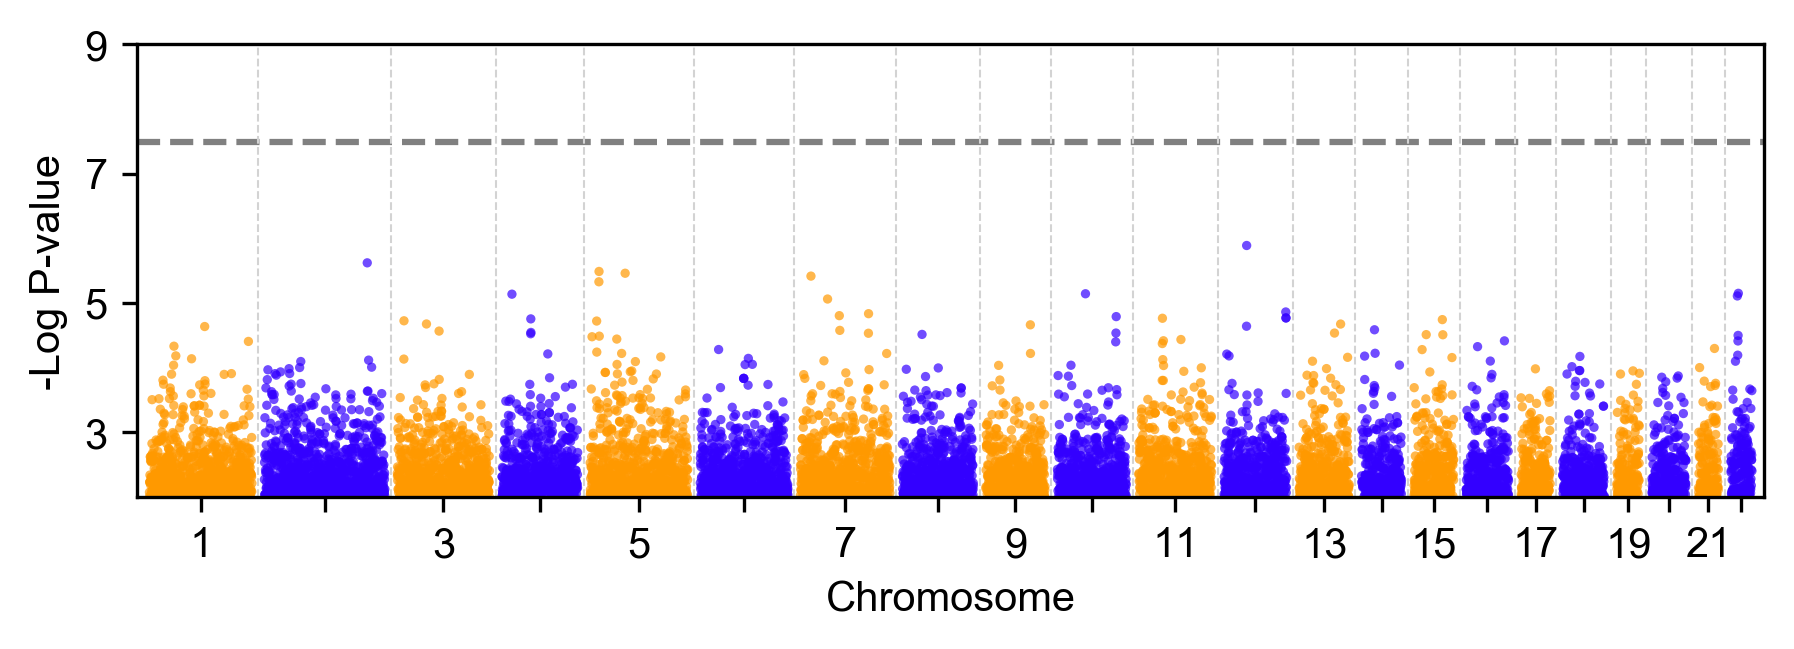

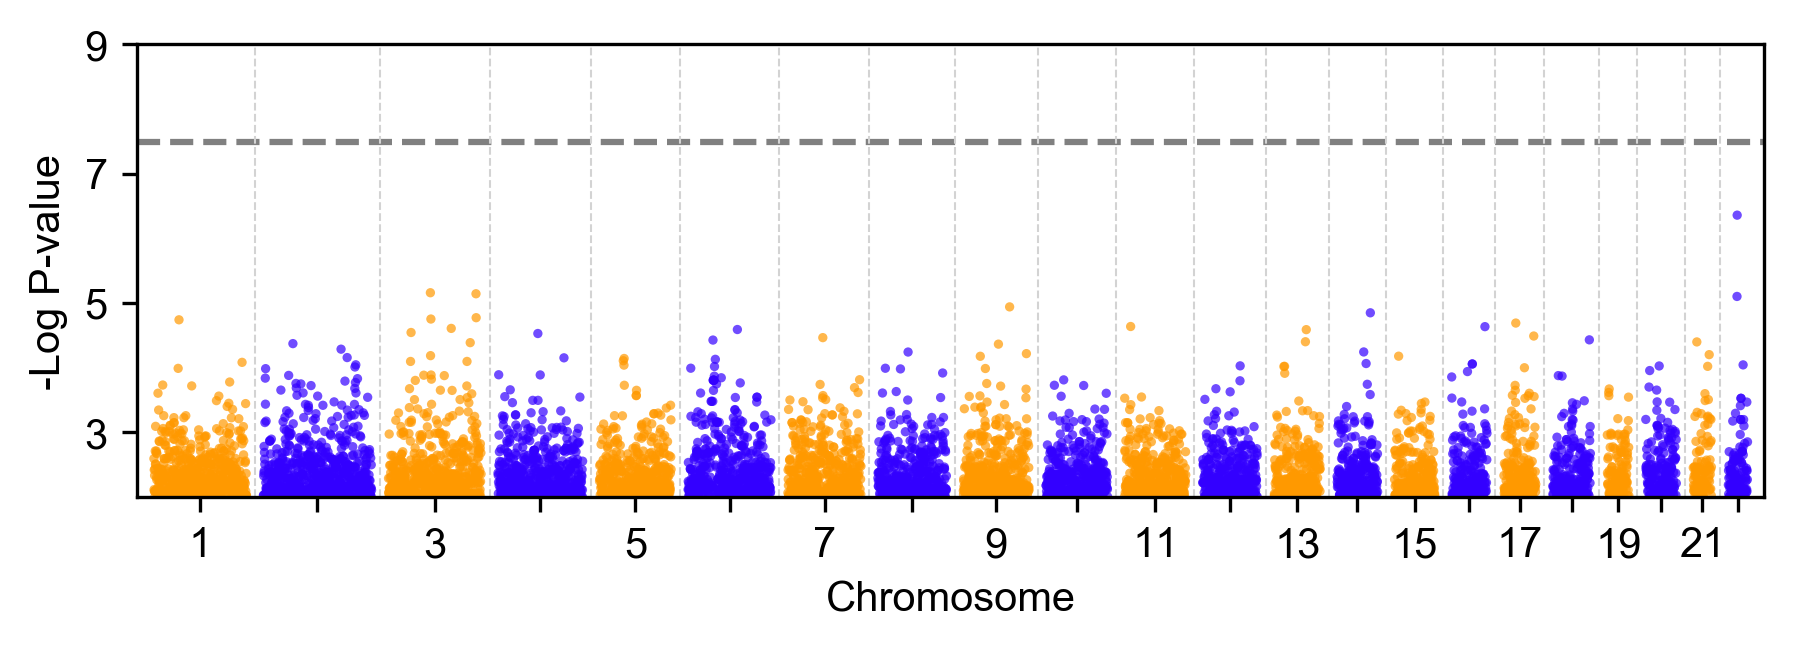

In [39]:
#chroms = [str(x) for x in range(1,23)]+['X'] # for some reason, no X
chroms = [str(x) for x in range(1,23)]
chrlist = []
for i in range(len(chroms)):
    if (i % 2) == 0:
        chrlist.append(chroms[i])
    else:
        chrlist.append('')

xlabel='CHR'
for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(7,2), dpi=300)
    
    ind = ~res[p]['PVAL'].isnull()
    P = res[p].loc[ind,'PVAL'].values
    logP = -1*np.log10(P)
    bp = res[p].loc[ind,'POS'].values
    chrs = res[p].loc[ind, 'CHR'].astype(str).values
    manhattan(bp, chrs, P=None, minusLogP=logP, ax=ax, colors=['#ff9900', '#3300ff'],
             chrlist=chroms, chrlabels=chrlist, plotheight=None, cut=2, dotsize=5, spacer=100,
             xlabel='', title='')
    xlim = ax.get_xlim()
    ax.hlines(y=-1*np.log10(3.24e-8), xmin=xlim[0], xmax=xlim[1], linestyle='--', color='gray')
    ax.set_xlim()
    ax.set_yticks([3,5,7,9])
    ax.set_xlabel('Chromosome')
    #plt.savefig("/home/sraju/analysis_20200629/GWAS/20211007_full_gwas_figures/" + p + "_manhattan_raw.png",
    #           bbox_inches = 'tight')

## Prepare Imputed GWAS

In [40]:
impbase = os.path.join(imputeddata, 'OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr{c}')
impbase

'../../data/tmp/GWAS/data/imputed/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr{c}'

In [43]:
chroms = [str(x) for x in range(1,23)] + ['X']
praw_adats = []
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    pdir_impdata = os.path.join(pdir, 'imputed_data')
    if not os.path.exists(pdir_impdata): os.mkdir(pdir_impdata)
    pdir_imp_dosage_data = os.path.join(pdir, 'imputed_dosage_data')
    sampfn = os.path.join(pdir, 'samples.txt')
    samps = pd.read_csv(sampfn, sep='\t', header=None)
    sampfn_fix = sampfn.replace('.txt', '_noFID.txt')
    samps[1].to_csv(sampfn_fix, index=False, header=False)
    for c in chroms:
        inv = impbase.format(c=c)
        outfn = os.path.join(pdir_impdata, inv.split('/')[-1].split('chr')[0] +'{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.mac_{mac}.chr{c}'.format(p=p, maf=maf, hwe=hwe, geno=geno, mac=mac, c=c))
        filt_cmd = 'plink2 --export vcf vcf-dosage=DS-force id-paste=iid bgz --pfile {inv} --keep {samples} --keep-allele-order --maf {maf} --hwe {hwe} --geno {geno} --mac {mac} --out {out} --set-all-var-ids @:#[b37]\$r,\$a'.format(inv=inv, samples=sampfn_fix, out=outfn, maf=maf, hwe=hwe, geno=geno, mac=mac)
        print(filt_cmd)
        !{filt_cmd}
        print('--------------------------\n\n\n\n\n\n\n')

plink2 --export vcf vcf-dosage=DS-force id-paste=iid bgz --pfile ../../data/tmp/GWAS/data/imputed/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr1 --keep ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/samples_noFID.txt --keep-allele-order --maf 1e-2 --hwe 1e-6 --geno 5e-2 --mac 25 --out ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr1 --set-all-var-ids @:#[b37]\$r,\$a
PLINK v2.00a3LM 64-bit Intel (1 Jul 2021)      www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr1.log.
Options in effect:
  --export vcf vcf-dosag

In [44]:
resdir

'../../data/tmp/GWAS/outcome_H3covar_20230804'

In [45]:
remotedir = 'gs://popgen-gwas/data/analysis/outcome_H3covar_20230804'

In [46]:
cpcmd = 'gsutil -m rsync -r %s %s' % (resdir, remotedir)
cpcmd

'gsutil -m rsync -r ../../data/tmp/GWAS/outcome_H3covar_20230804 gs://popgen-gwas/data/analysis/outcome_H3covar_20230804'

In [47]:
!{cpcmd}

Building synchronization state...
Starting synchronization...
Copying file://../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr17.vcf.gz [Content-Type=text/vcard]...
Copying file://../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr22.vcf.gz [Content-Type=text/vcard]...
Copying file://../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr15.vcf.gz [Content-Type=text/vcard]...
Copying file://../../data/tmp/GWAS/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-

In [49]:
#imputed gwas
scriptfn = 'gs://ebola-gwas-lbr/Code/run_GMMAT_premade_model_vcf_dosage.R' # score test
container = 'quay.io/dkotliar/gmmat_mkl:0.4'
ncores = 7
    
subcmdbase = '''dsub --project sabeti-ebola-gwas \
--name %s --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" \
--logging %s \
--image %s \
--input SCRIPT=%s \
--input NULLFILE=%s \
--input VCF_FILE=%s \
--output OUTPUT=%s \
--command '%s\''''   

cmd = 'Rscript --vanilla ${SCRIPT} ${NULLFILE} ${VCF_FILE} ${OUTPUT} %d' % (ncores)    
#need to update
impfnbase = 'OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr{c}.vcf.gz'
chroms = list([str(x) for x in range(1,23)]) + ['X']
#for p in phenotypes:
for p in phenotypes:
    pdir = '{base}/{p}'.format(base=remotedir, p=p)
    phenoresdir = os.path.join(pdir, 'results')
    rawgwasdir = os.path.join(phenoresdir, 'raw_gwas')

    covarstr = ''.join(covarmap[p])
    nulloutfile = os.path.join(rawgwasdir, "gmmat.%s.%s.nullmodel.rds" % (covarstr, p))
    
    logdir = os.path.join(phenoresdir, 'imputed_gwas_log')
    remoteresdir = os.path.join(phenoresdir, 'imputed_gwas')
    
    logbase = os.path.join(logdir, "{job-name}-{job-id}.log")    
    for c in chroms:
        vcfbase = os.path.join(pdir, 'imputed_data', impfnbase.format(c=c, p=p))
        outfile = os.path.join(remoteresdir, "gmmat.fromVCFdosage.%s.%s.%s.results.tsv" % (covarstr, p, c)) # score test
        name = 'dosage.%s.%s' % (p, c)
        fullcmd = subcmdbase % (name,logbase,container,scriptfn, nulloutfile, vcfbase, outfile, cmd)
        print(fullcmd)
        !{fullcmd}

dsub --project sabeti-ebola-gwas --name dosage.MergeEpoch_NG_Died_vs_Survived.1 --min-ram 16 --min-cores 8 --boot-disk-size 600 --disk-size 1000 --zones "us-east1-b" --logging gs://popgen-gwas/data/analysis/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/results/imputed_gwas_log/{job-name}-{job-id}.log --image quay.io/dkotliar/gmmat_mkl:0.4 --input SCRIPT=gs://ebola-gwas-lbr/Code/run_GMMAT_premade_model_vcf_dosage.R --input NULLFILE=gs://popgen-gwas/data/analysis/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/results/raw_gwas/gmmat.SEXPCsH3.MergeEpoch_NG_Died_vs_Survived.nullmodel.rds --input VCF_FILE=gs://popgen-gwas/data/analysis/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.mac_25.chr1.vcf.gz --output OUTPUT=gs://popgen-gwas/data/analysis/outcome_H3covar_20230804/MergeEpoch_NG_Died_vs_Survived/results/imputed_gwas/gmmat.fromVCFdosage.

In [23]:
resdir

'../../data/tmp/GWAS/outcome_H3covar_20220315'

In [19]:
resdir = '../../data/tmp/GWAS/outcome_noH3covar_20220208'

In [118]:
# define covariates to be used in GLMM
covarmap = {'MergeEpoch_NG_Died_vs_Survived': ['SEX',  'PCs', 'H3'],
 'MergeEpoch_SL_Died_vs_Survived': ['SEX', 'PCs', 'H3']}

In [119]:
phenotypes = ['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived']

In [122]:
chroms = list([str(x) for x in range(1,23)]) + ['X']
imputedres = {}
for p in phenotypes:
    pdir = '{base}/{p}'.format(base=remotedir, p=p)
    phenoresdir = os.path.join(pdir, 'results')
    remoteresdir = os.path.join(phenoresdir, 'imputed_gwas')
    print(remoteresdir)
    imputedres[p] = []
    covarstr = ''.join(covarmap[p])
    for c in chroms:
        # score test results
        outfn = os.path.join(remoteresdir, "gmmat.fromVCFdosage.%s.%s.%s.results.tsv" % (covarstr, p, c)) # score test
        imputedres[p].append(pd.read_csv(outfn, sep='\t'))
    imputedres[p] = pd.concat(imputedres[p], axis=0)

gs://popgen-gwas/data/analysis/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/imputed_gwas
gs://popgen-gwas/data/analysis/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/imputed_gwas


In [123]:
# Dylan said this will let us edit in illustrator, we shall see!
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [124]:
title_map = {'MergeEpoch_SL_Died_vs_Survived':'Sierra Leone',
 'MergeEpoch_NG_Died_vs_Survived':'Nigeria'}

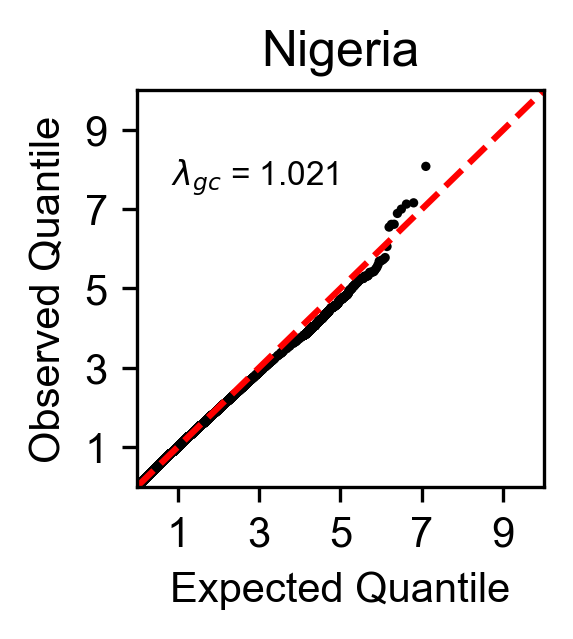

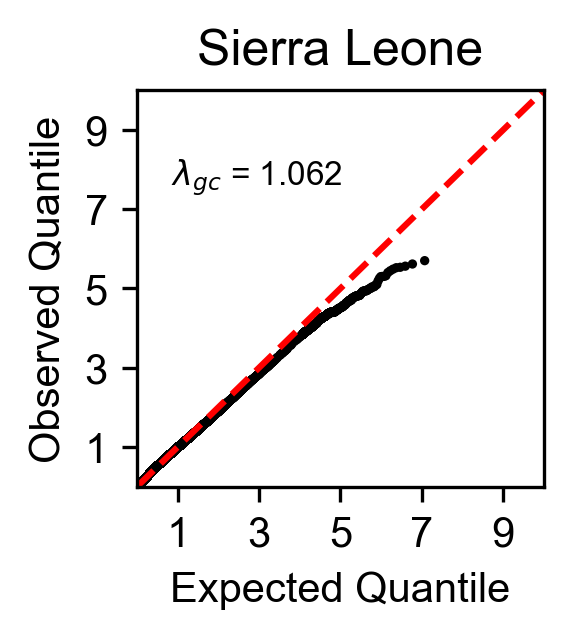

In [125]:
for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(1.75,1.75), dpi=300)
    ax = qqplot(imputedres[p]['PVAL'].dropna().values.reshape(-1),
       fill_dens=0.2, 
       title=title_map[p],ax=ax, rasterized=True)
    if p == 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl':
        ax.set_xticks([2,4,6,8,10])
        ax.set_yticks([2,4,6,8,10])
        ax.set_ylim([0, 11])
        ax.set_xlim([0, 11])
    else:
        ax.set_xticks([1,3,5,7,9])
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
        ax.set_xlim([0, 10])
        
    ax.set_xlabel('Expected Quantile')
    ax.set_ylabel('Observed Quantile')
    gc = np.median(chi2.ppf(1-imputedres[p]['PVAL'].dropna(), df=1)) / chi2.ppf(.5, df=1)

    plt.figtext(.19, .7, '$\lambda_{gc}$ = %.3f' % gc, fontsize=8)
    
    outbase = "../../figures/" + p + "_qqplot_imp"
    plt.savefig(outbase + ".png", bbox_inches = 'tight')
    plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

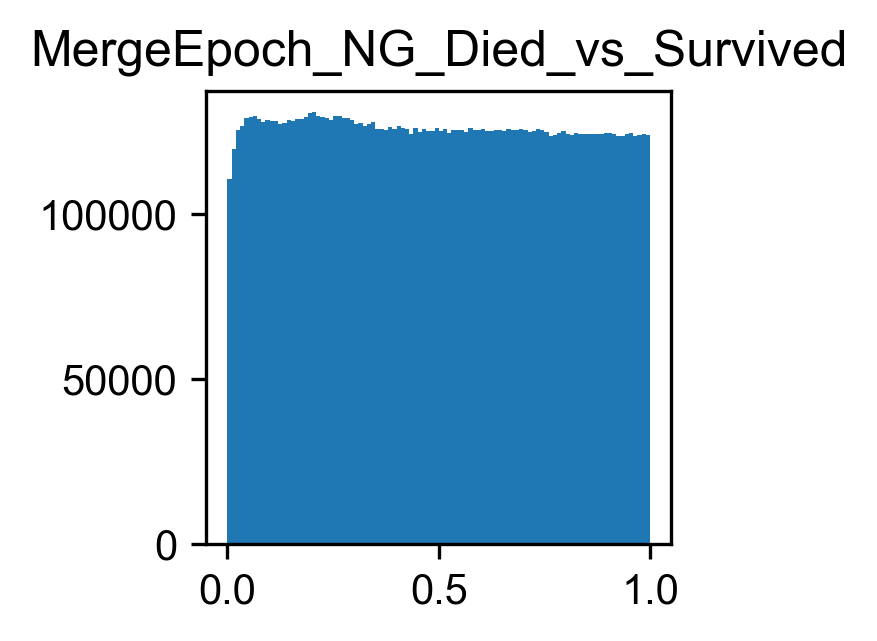

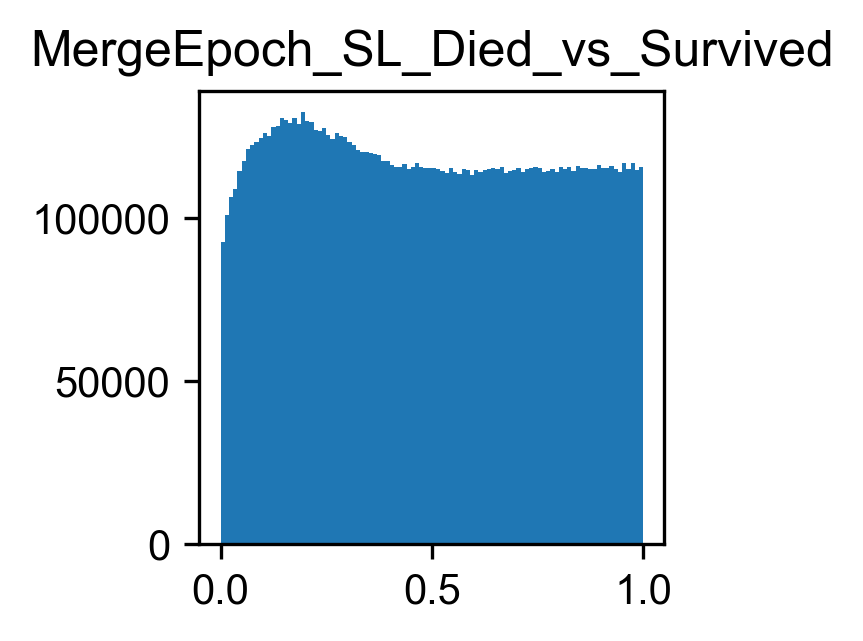

In [126]:
for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(2,2), dpi=300)
    _ = ax.hist(imputedres[p]['PVAL'], bins=100)
    _ = ax.set_title(p)

In [127]:
phenotypes

['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived']

In [3]:
303*2*0.043624

26.436144000000002

In [128]:
for p in phenotypes:
    imputedres[p].index = imputedres[p]['SNP'].values
    display(imputedres[p].sort_values(by='PVAL').head(10))

,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
"3:7330265[b37]A,G","3:7330265[b37]A,G",3,7330265,A,G,303,0.016502,0.043624,14.357523,6.208462,8.302983e-09
"3:7332556[b37]G,A","3:7332556[b37]G,A",3,7332556,G,A,303,0.009901,0.038333,12.259633,5.166586,6.907457e-08
"3:7302129[b37]G,T","3:7302129[b37]G,T",3,7302129,G,T,303,0.009901,0.028333,10.100319,3.523992,7.430473e-08
"3:7287290[b37]T,C","3:7287290[b37]T,C",3,7287290,T,C,303,0.003300,0.033113,10.616018,3.970805,9.958115e-08
"3:7322569[b37]C,T","3:7322569[b37]C,T",3,7322569,C,T,303,0.016502,0.033557,11.253078,4.539031,1.278547e-07
"22:30619983[b37]G,A","22:30619983[b37]G,A",22,30619983,G,A,303,0.029703,0.477891,-27.880712,29.133850,2.399107e-07
"3:7279612[b37]G,C","3:7279612[b37]G,C",3,7279612,G,C,303,0.000000,0.031353,10.011077,3.757522,2.410557e-07
"17:31757349[b37]C,T","17:31757349[b37]C,T",17,31757349,C,T,303,0.036304,0.042808,13.026161,6.435683,2.825228e-07
"2:215526735[b37]G,A","2:215526735[b37]G,A",2,215526735,G,A,303,0.042904,0.693103,-26.155230,28.280368,8.729406e-07
"12:44394175[b37]C,T","12:44394175[b37]C,T",12,44394175,C,T,303,0.000000,0.089109,15.746982,10.802814,1.659274e-06


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
"15:56116231[b37]A,T","15:56116231[b37]A,T",15,56116231,A,T,108,0.009259,0.074766,-7.698558,2.621555,0.000002
"3:73438059[b37]G,A","3:73438059[b37]G,A",3,73438059,G,A,108,0.000000,0.356481,-14.545826,9.515900,0.000002
"11:134892791[b37]T,C","11:134892791[b37]T,C",11,134892791,T,C,108,0.018519,0.028302,-4.729203,1.016949,0.000003
"22:32779924[b37]A,G","22:32779924[b37]A,G",22,32779924,A,G,108,0.000000,0.250000,-12.461739,7.101123,0.000003
"15:56117779[b37]G,A","15:56117779[b37]G,A",15,56117779,G,A,108,0.009259,0.074766,-7.649980,2.681891,0.000003
"2:172990449[b37]A,T","2:172990449[b37]A,T",2,172990449,A,T,108,0.009259,0.093458,-8.324411,3.199293,0.000003
"6:159489169[b37]C,T","6:159489169[b37]C,T",6,159489169,C,T,108,0.009259,0.037383,-5.445274,1.380276,0.000004
"2:172987675[b37]G,A","2:172987675[b37]G,A",2,172987675,G,A,108,0.037037,0.206731,-10.732789,5.412043,0.000004
"15:34269975[b37]T,C","15:34269975[b37]T,C",15,34269975,T,C,108,0.027778,0.152381,-10.574371,5.343783,0.000005
"14:89776334[b37]G,A","14:89776334[b37]G,A",14,89776334,G,A,108,0.009259,0.112150,-8.768674,3.687194,0.000005


In [129]:
imputedres['MergeEpoch_NG_Died_vs_Survived'].loc[['19:2389044[b37]A,G', '6:28888948[b37]G,A', '17:33192408[b37]C,G'], :]

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
"19:2389044[b37]A,G",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"6:28888948[b37]G,A",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"17:33192408[b37]C,G","17:33192408[b37]C,G",17,33192408.0,C,G,303.0,0.006601,0.036545,0.666544,4.48872,0.75306


In [130]:
imputedres['MergeEpoch_SL_Died_vs_Survived'].loc[['3:7330265[b37]A,G', '17:33192408[b37]C,G', '19:2389044[b37]A,G', '6:28888948[b37]G,A'], :]

,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
"3:7330265[b37]A,G","3:7330265[b37]A,G",3,7330265.0,A,G,108.0,0.018519,0.047170,-0.740669,1.688912,0.568726
"17:33192408[b37]C,G","17:33192408[b37]C,G",17,33192408.0,C,G,108.0,0.027778,0.076190,-0.870693,2.482491,0.580528
"19:2389044[b37]A,G",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"6:28888948[b37]G,A","6:28888948[b37]G,A",6,28888948.0,G,A,108.0,0.000000,0.037037,-0.611531,1.439502,0.610264


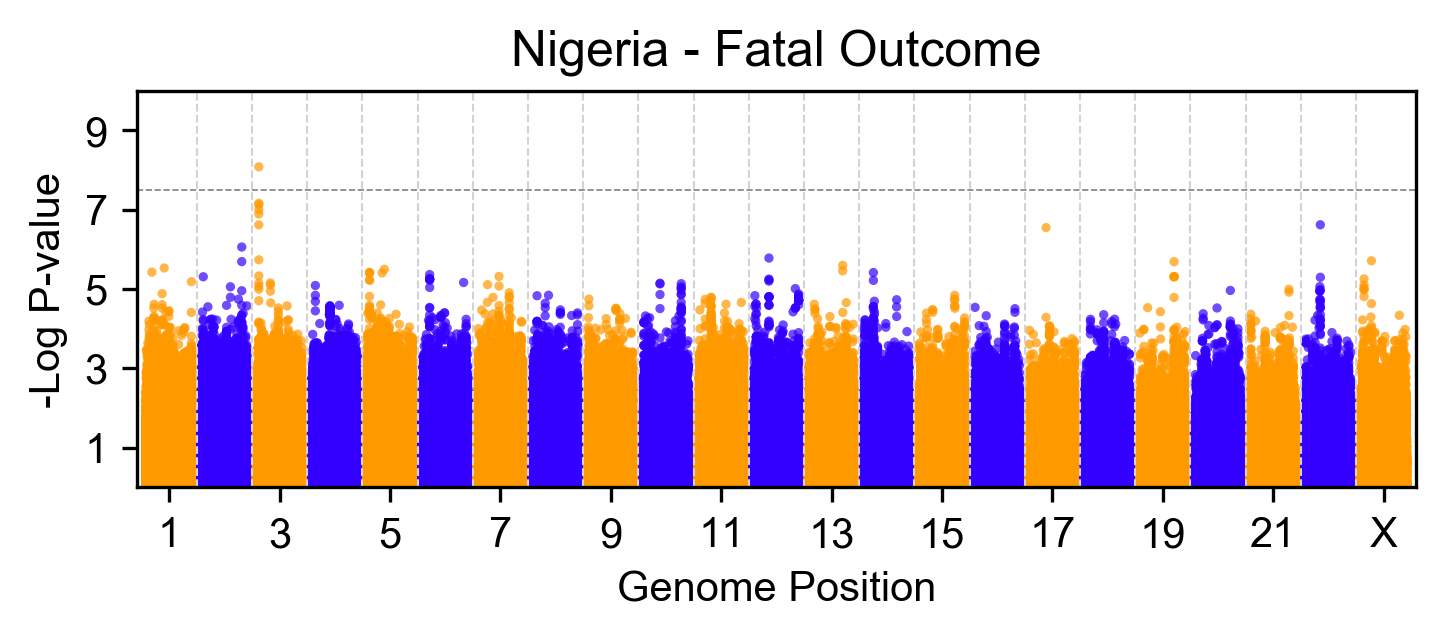

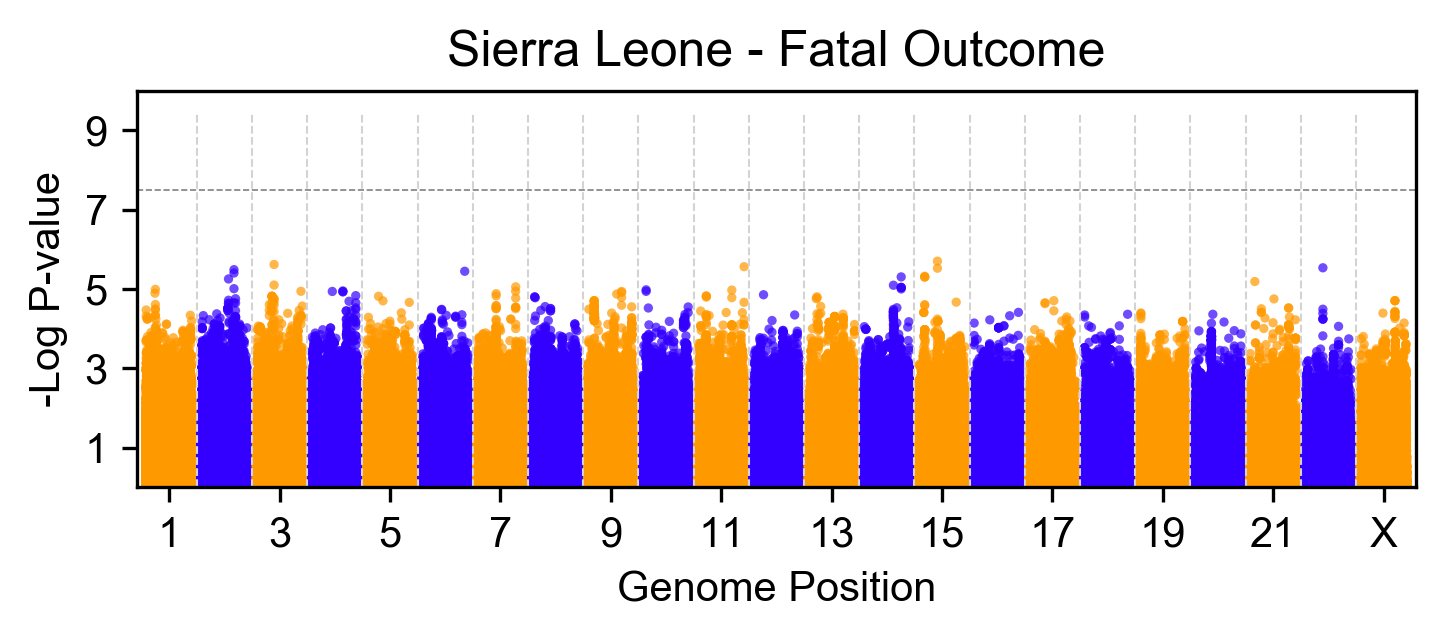

In [131]:
chroms = [str(x) for x in range(1,23)]+['X'] 
chrlist = []
for i in range(len(chroms)):
    if (i % 2) == 0:
        chrlist.append(chroms[i])
    else:
        chrlist.append('')

xlabel='CHR'

title_map = {'MergeEpoch_SL_Died_vs_Survived':'Sierra Leone - Fatal Outcome',
 'MergeEpoch_NG_Died_vs_Survived':'Nigeria - Fatal Outcome'}

for p in phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(5.5,1.75), dpi=300)
    ind = ~imputedres[p]['PVAL'].isnull()
    P = imputedres[p].loc[ind,'PVAL'].values
    logP = -1*np.log10(P)
    bp = imputedres[p].loc[ind,'POS'].values
    chrs = imputedres[p].loc[ind, 'CHR'].astype(str).values
    manhattan_fixwidth(bp, chrs, P=None, minusLogP=logP, ax=ax, colors=['#ff9900', '#3300ff'],
             chrlist=chroms, chrlabels=chrlist, plotheight=None, cut=0, dotsize=5, spacer=.2,
             xlabel='', title='', only_altticks=True, rasterized=True)
    xlim = ax.get_xlim()
    ax.hlines(y=-1*np.log10(3.24e-8), xmin=xlim[0], xmax=xlim[1], linestyle='--', color='gray', lw=0.4, zorder=-10)

    ax.set_yticks([1,3,5,7,9])
    ax.set_ylim([0, 10])
    
    ax.set_xlabel('Genome Position')
    ax.set_title(title_map[p])
    
    
    outbase = "../../figures/" + p + "_manhattan_imp"
    plt.savefig(outbase + ".png", bbox_inches = 'tight')
    plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

In [34]:
for p in phenotypes:
    imputedres[p].index = imputedres[p]['SNP'].values
    imputedres[p] = imputedres[p].sort_values(by='PVAL')


In [35]:
for p in phenotypes:
    imputedres[p].to_csv('../../tables/SuppTable_FullAssociationStats_%s_clinicaloutcome.tsv' % p.split('_')[1], sep='\t', index=False)

In [16]:
phenotypes

['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived']

In [15]:
imputedres = {}
for p in phenotypes:
    imputedres[p] = pd.read_csv('../../tables/SuppTable_FullAssociationStats_%s_clinicaloutcome.tsv' % p.split('_')[1], sep='\t', index_col=0)

In [16]:
for p in phenotypes:
    print(p)
    display(imputedres[p].head(10))

MergeEpoch_NG_Died_vs_Survived


,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,
"3:7330265[b37]A,G",3,7330265,A,G,303,0.016502,0.043624,14.357523,6.208462,8.302983e-09
"3:7332556[b37]G,A",3,7332556,G,A,303,0.009901,0.038333,12.259633,5.166586,6.907457e-08
"3:7302129[b37]G,T",3,7302129,G,T,303,0.009901,0.028333,10.100319,3.523992,7.430473e-08
"3:7287290[b37]T,C",3,7287290,T,C,303,0.003300,0.033113,10.616018,3.970805,9.958115e-08
"3:7322569[b37]C,T",3,7322569,C,T,303,0.016502,0.033557,11.253078,4.539031,1.278547e-07
"22:30619983[b37]G,A",22,30619983,G,A,303,0.029703,0.477891,-27.880712,29.133850,2.399107e-07
"3:7279612[b37]G,C",3,7279612,G,C,303,0.000000,0.031353,10.011077,3.757522,2.410557e-07
"17:31757349[b37]C,T",17,31757349,C,T,303,0.036304,0.042808,13.026161,6.435683,2.825228e-07
"2:215526735[b37]G,A",2,215526735,G,A,303,0.042904,0.693103,-26.155230,28.280368,8.729406e-07


MergeEpoch_SL_Died_vs_Survived


,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,
"15:56116231[b37]A,T",15,56116231,A,T,108,0.009259,0.074766,-7.698558,2.621555,0.000002
"3:73438059[b37]G,A",3,73438059,G,A,108,0.000000,0.356481,-14.545826,9.515900,0.000002
"11:134892791[b37]T,C",11,134892791,T,C,108,0.018519,0.028302,-4.729203,1.016949,0.000003
"22:32779924[b37]A,G",22,32779924,A,G,108,0.000000,0.250000,-12.461739,7.101123,0.000003
"15:56117779[b37]G,A",15,56117779,G,A,108,0.009259,0.074766,-7.649980,2.681891,0.000003
"2:172990449[b37]A,T",2,172990449,A,T,108,0.009259,0.093458,-8.324411,3.199293,0.000003
"6:159489169[b37]C,T",6,159489169,C,T,108,0.009259,0.037383,-5.445274,1.380276,0.000004
"2:172987675[b37]G,A",2,172987675,G,A,108,0.037037,0.206731,-10.732789,5.412043,0.000004
"15:34269975[b37]T,C",15,34269975,T,C,108,0.027778,0.152381,-10.574371,5.343783,0.000005


In [17]:
(imputedres['MergeEpoch_NG_Died_vs_Survived']['PVAL']<3.24e-8).sum()

1

In [23]:
imputedres['MergeEpoch_NG_Died_vs_Survived'].sort_values(by='PVAL').head(10)

,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,
"3:7330265[b37]A,G",3,7330265,A,G,303,0.016502,0.043624,14.357523,6.208462,8.302983e-09
"3:7332556[b37]G,A",3,7332556,G,A,303,0.009901,0.038333,12.259633,5.166586,6.907457e-08
"3:7302129[b37]G,T",3,7302129,G,T,303,0.009901,0.028333,10.100319,3.523992,7.430473e-08
"3:7287290[b37]T,C",3,7287290,T,C,303,0.003300,0.033113,10.616018,3.970805,9.958115e-08
"3:7322569[b37]C,T",3,7322569,C,T,303,0.016502,0.033557,11.253078,4.539031,1.278547e-07
"22:30619983[b37]G,A",22,30619983,G,A,303,0.029703,0.477891,-27.880712,29.133850,2.399107e-07
"3:7279612[b37]G,C",3,7279612,G,C,303,0.000000,0.031353,10.011077,3.757522,2.410557e-07
"17:31757349[b37]C,T",17,31757349,C,T,303,0.036304,0.042808,13.026161,6.435683,2.825228e-07
"2:215526735[b37]G,A",2,215526735,G,A,303,0.042904,0.693103,-26.155230,28.280368,8.729406e-07


In [18]:
(imputedres['MergeEpoch_SL_Died_vs_Survived']['PVAL']<3.24e-8).sum()

0

In [22]:
p = 'MergeEpoch_NG_Died_vs_Survived'
sigvars = ['17:33192408[b37]C,G', '19:2389044[b37]A,G', '7:146308575[b37]T,C', '13:88537883[b37]G,A']
imputedres[p].loc[sigvars, :]

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,
"17:33192408[b37]C,G",17,33192408.0,C,G,303.0,0.006601,0.036545,0.666544,4.488720,0.753060
"19:2389044[b37]A,G",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"7:146308575[b37]T,C",7,146308575.0,T,C,303.0,0.009901,0.026667,0.573411,3.300152,0.752272
"13:88537883[b37]G,A",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
p = 'MergeEpoch_SL_Died_vs_Survived'
sigvars = ['17:33192408[b37]C,G', '19:2389044[b37]A,G', '7:146308575[b37]T,C', '13:88537883[b37]G,A']
imputedres[p].loc[sigvars, :]

,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,
"17:33192408[b37]C,G",17,33192408.0,C,G,108.0,0.027778,0.076190,-0.870693,2.482491,0.580528
"19:2389044[b37]A,G",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"7:146308575[b37]T,C",7,146308575.0,T,C,108.0,0.018519,0.028302,1.169672,0.797394,0.190241
"13:88537883[b37]G,A",13,88537883.0,G,A,108.0,0.018519,0.014151,0.695395,0.373898,0.255435


In [24]:
leadvar = '3:7330265[b37]A,G'

In [25]:
suscept = {}
suscept['NG'] = pd.read_csv('../../tables/SuppTable_FullAssociationStats_NG_casecontrol_20220828.tsv', sep='\t', index_col=0)
suscept['SL'] = pd.read_csv('../../tables/SuppTable_FullAssociationStats_SL_casecontrol_20220828.tsv', sep='\t', index_col=0)

In [26]:
suscept['NG'].loc[leadvar, :]

CHR                 3
POS           7330265
REF                 A
ALT                 G
N                1598
MISSRATE    0.0206508
AF          0.0507987
SCORE        -3.66398
VAR           11.2277
PVAL         0.274188
Name: 3:7330265[b37]A,G, dtype: object

In [27]:
suscept['SL'].loc[leadvar, :]

CHR                  3
POS            7330265
REF                  A
ALT                  G
N                  921
MISSRATE    0.00651466
AF           0.0300546
SCORE          1.64181
VAR            4.99097
PVAL          0.462399
Name: 3:7330265[b37]A,G, dtype: object

In [28]:
idmap = pd.read_csv('gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/varidmap.tsv', sep='\t')
var2id = dict(zip(idmap['POSID'], idmap['ID']))
idmap.head()

,POSID,ID
0,"1:723918[b37]G,A",rs144434834
1,"1:724103[b37]A,G",rs111533735
2,"1:724169[b37]A,G",.
3,"1:724300[b37]C,T",rs12069907
4,"1:725286[b37]G,A",rs111203397


In [29]:
var2id[leadvar]

'rs9870087'

In [30]:
imputedres['MergeEpoch_SL_Died_vs_Survived'].loc[leadvar, :]

CHR                 3
POS           7330265
REF                 A
ALT                 G
N                 108
MISSRATE    0.0185185
AF          0.0471698
SCORE       -0.740669
VAR           1.68891
PVAL         0.568726
Name: 3:7330265[b37]A,G, dtype: object

## Run meta-analysis

In [28]:
in1 = '../../tables/SuppTable_FullAssociationStats_NG_clinicaloutcome.tsv'
in2 = '../../tables/SuppTable_FullAssociationStats_SL_clinicaloutcome.tsv'
metafn = '../../tables/SuppTable_FullAssociationStats_MetaAnalyzed_clinicaloutcome.tsv'
cmd = 'Rscript ../../code/gwas_analysis/run_GMMAT_meta.R %s %s %s' % (in1, in2, metafn)
print(cmd)
!{cmd}

Rscript ../../code/gwas_analysis/run_GMMAT_meta.R ../../tables/SuppTable_FullAssociationStats_NG_clinicaloutcome.tsv ../../tables/SuppTable_FullAssociationStats_SL_clinicaloutcome.tsv ../../tables/SuppTable_FullAssociationStats_MetaAnalyzed_clinicaloutcome.tsv


In [19]:
metafn = '../../tables/SuppTable_FullAssociationStats_MetaAnalyzed_clinicaloutcome.tsv'
meta = pd.read_csv(metafn, sep='\t')
meta.head()

,SNP,A1,A2,N,AF,SCORE,VAR,PVAL
0,"3:7330265[b37]A,G",G,A,411,0.044556,13.616854,7.897374,1.263157e-06
1,"3:7332556[b37]G,A",A,G,411,0.038176,11.589678,6.604329,6.488960e-06
2,"3:7302129[b37]G,T",T,G,411,0.025754,10.597952,4.271529,2.931619e-07
3,"3:7287290[b37]T,C",C,T,411,0.030494,10.762488,4.908486,1.187023e-06
4,"3:7322569[b37]C,T",T,C,411,0.034750,10.515881,6.016999,1.810844e-05


In [21]:
(meta['PVAL']<3.24e-8).sum()

1

In [22]:
meta.sort_values(by='PVAL').head(10)

,SNP,A1,A2,N,AF,SCORE,VAR,PVAL
5,"22:30619983[b37]G,A",A,G,411,0.431642,-35.751791,37.482477,5.232393e-09
7,"17:31757349[b37]C,T",T,C,303,0.042808,13.026161,6.435683,2.825228e-07
2,"3:7302129[b37]G,T",T,G,411,0.025754,10.597952,4.271529,2.931619e-07
6,"3:7279612[b37]G,C",C,G,411,0.027981,10.518844,4.522759,7.569998e-07
8,"2:215526735[b37]G,A",A,G,303,0.693103,-26.155230,28.280368,8.729406e-07
3,"3:7287290[b37]T,C",C,T,411,0.030494,10.762488,4.908486,1.187023e-06
0,"3:7330265[b37]A,G",G,A,411,0.044556,13.616854,7.897374,1.263157e-06
40,"5:8702372[b37]A,G",G,A,411,0.395611,30.306659,39.304855,1.337544e-06
2424,"4:147973980[b37]T,G",G,T,411,0.027107,-10.377221,4.698858,1.690930e-06
147,"11:83767844[b37]G,A",A,G,411,0.542579,-30.597563,41.185323,1.862732e-06


In [30]:
meta = meta.sort_values(by='PVAL')

In [31]:
meta.head(10)

,SNP,A1,A2,N,AF,SCORE,VAR,PVAL
5,"22:30619983[b37]G,A",A,G,411,0.431642,-35.751791,37.482477,5.232393e-09
7,"17:31757349[b37]C,T",T,C,303,0.042808,13.026161,6.435683,2.825228e-07
2,"3:7302129[b37]G,T",T,G,411,0.025754,10.597952,4.271529,2.931619e-07
6,"3:7279612[b37]G,C",C,G,411,0.027981,10.518844,4.522759,7.569998e-07
8,"2:215526735[b37]G,A",A,G,303,0.693103,-26.155230,28.280368,8.729406e-07
3,"3:7287290[b37]T,C",C,T,411,0.030494,10.762488,4.908486,1.187023e-06
0,"3:7330265[b37]A,G",G,A,411,0.044556,13.616854,7.897374,1.263157e-06
40,"5:8702372[b37]A,G",G,A,411,0.395611,30.306659,39.304855,1.337544e-06
2424,"4:147973980[b37]T,G",G,T,411,0.027107,-10.377221,4.698858,1.690930e-06
147,"11:83767844[b37]G,A",A,G,411,0.542579,-30.597563,41.185323,1.862732e-06


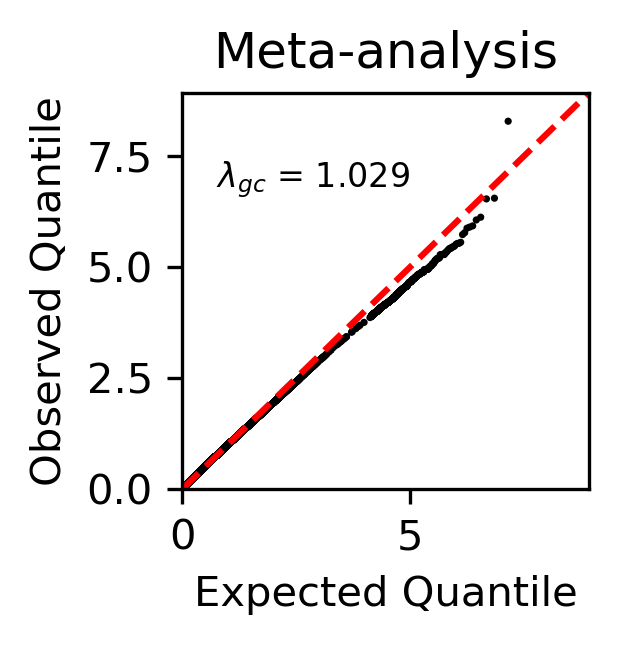

In [32]:
(fig,ax) = plt.subplots(1,1, figsize=(1.75,1.75), dpi=300)
P = meta['PVAL'].dropna().values.reshape(-1)
ax = qqplot(P, num_top_points=1000, numsample=50000, fill_dens=0.2, title='Meta-analysis',ax=ax, dot_size=3, rasterized=True)

gc = np.median(chi2.ppf(1-meta['PVAL'].dropna(), df=1)) / chi2.ppf(.5, df=1)

plt.figtext(.19, .7, '$\lambda_{gc}$ = %.3f' % gc, fontsize=8)
    
outbase = "../../figures/metaanalysis_clinicaloutcome_qqplot_imp"
plt.savefig(outbase + ".png", bbox_inches = 'tight')
plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

In [33]:
meta['POS'] = meta['SNP'].apply(lambda x: x.split(':')[1].split('[')[0]).astype(float)
meta['CHR'] = meta['SNP'].apply(lambda x: x.split(':')[0])
meta['CHR'] = meta['CHR'].replace({'X':'23'}).astype(int)
meta = meta.sort_values(by=['CHR', 'POS'], ascending=True)
meta['CHR'] = meta['CHR'].replace({23:'X'}).astype(str)


In [34]:
meta = meta.rename(columns={'A2':'REF', 'A1':'ALT'})

In [35]:
meta = meta[['SNP', 'CHR', 'POS', 'REF', 'ALT', 'N',  'AF', 'SCORE', 'VAR', 'PVAL']]

In [36]:
meta.to_csv('../../tables/SuppTable_FullAssociationStats_MetaAnalyzed_clinicaloutcome_fixCols.tsv', sep='\t', index=False)


In [114]:
meta.sort_values(by='PVAL', ascending=True).head(50)

,SNP,CHR,POS,REF,ALT,N,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,
"22:30619983[b37]G,A","22:30619983[b37]G,A",22,30619983.0,G,A,411,0.431642,-35.751791,37.482477,5.232393e-09
"17:31757349[b37]C,T","17:31757349[b37]C,T",17,31757349.0,C,T,303,0.042808,13.026161,6.435683,2.825228e-07
"3:7302129[b37]G,T","3:7302129[b37]G,T",3,7302129.0,G,T,411,0.025754,10.597952,4.271529,2.931619e-07
"3:7279612[b37]G,C","3:7279612[b37]G,C",3,7279612.0,G,C,411,0.027981,10.518844,4.522759,7.569998e-07
"2:215526735[b37]G,A","2:215526735[b37]G,A",2,215526735.0,G,A,303,0.693103,-26.155230,28.280368,8.729406e-07
"3:7287290[b37]T,C","3:7287290[b37]T,C",3,7287290.0,T,C,411,0.030494,10.762488,4.908486,1.187023e-06
"3:7330265[b37]A,G","3:7330265[b37]A,G",3,7330265.0,A,G,411,0.044556,13.616854,7.897374,1.263157e-06
"5:8702372[b37]A,G","5:8702372[b37]A,G",5,8702372.0,A,G,411,0.395611,30.306659,39.304855,1.337544e-06
"4:147973980[b37]T,G","4:147973980[b37]T,G",4,147973980.0,T,G,411,0.027107,-10.377221,4.698858,1.690930e-06


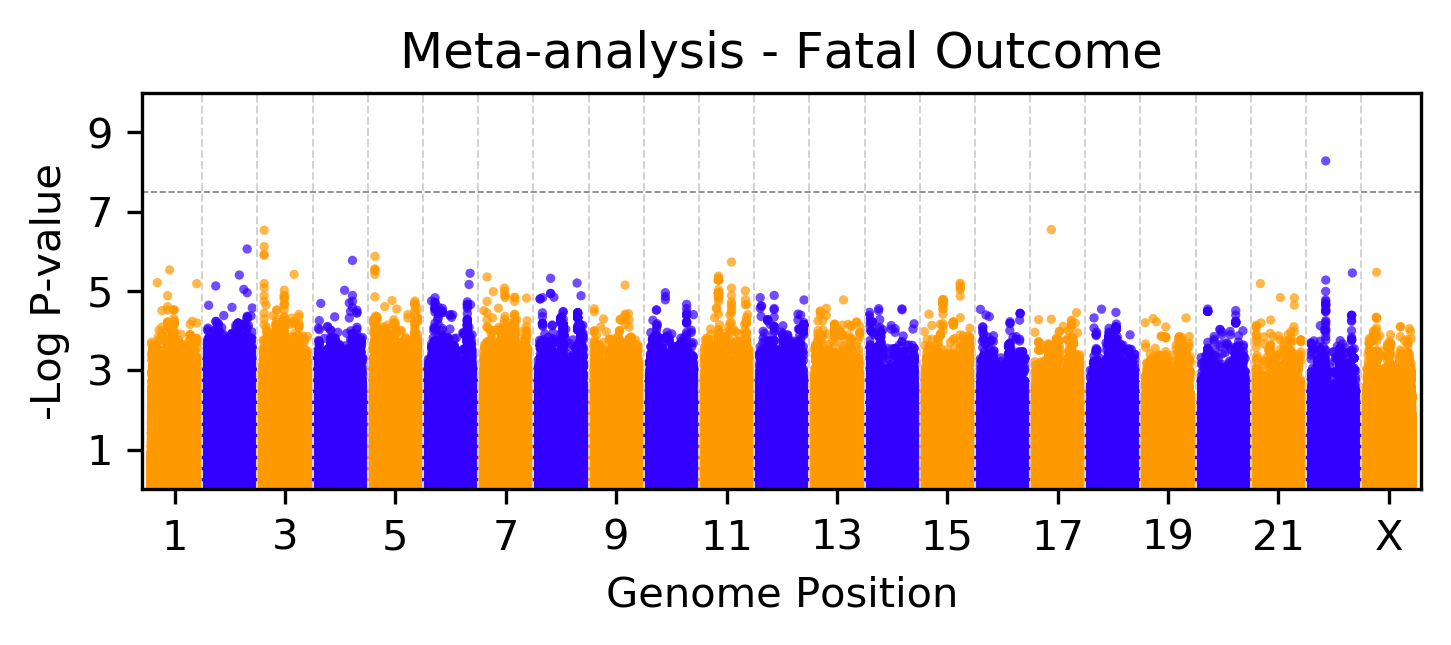

In [115]:
chroms = [str(x) for x in range(1,23)]+['X'] 
chrlist = []
for i in range(len(chroms)):
    if (i % 2) == 0:
        chrlist.append(chroms[i])
    else:
        chrlist.append('')

xlabel='CHR'

(fig,ax) = plt.subplots(1,1, figsize=(5.5,1.75), dpi=300)
ind = ~meta['PVAL'].isnull()
P = meta.loc[ind,'PVAL'].values
logP = -1*np.log10(P)
bp = meta.loc[ind,'POS'].values
chrs = meta.loc[ind, 'CHR'].astype(str).values
manhattan_fixwidth(bp, chrs, P=None, minusLogP=logP, ax=ax, colors=['#ff9900', '#3300ff'],
             chrlist=chroms, chrlabels=chrlist, plotheight=None, cut=0, dotsize=5, spacer=.2,
             xlabel='', title='', only_altticks=True, rasterized=True, linewidth=0.5)
xlim = ax.get_xlim()
ax.hlines(y=-1*np.log10(3.24e-8), xmin=xlim[0], xmax=xlim[1], linestyle='--', color='gray', lw=0.4, zorder=-10)

ax.set_yticks([1,3,5,7,9])
ax.set_ylim([0, 10])
    
ax.set_xlabel('Genome Position')
ax.set_title('Meta-analysis - Fatal Outcome')
    
    
outbase = "../../figures/metaanalysis_clinicaloutcome_manhattan_imp"
plt.savefig(outbase + ".png", bbox_inches = 'tight')
plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

In [38]:
imputedres['Meta-analysis'] = meta

In [39]:
imputedres['Meta-analysis'].index = imputedres['Meta-analysis']['SNP']

In [15]:
outcome_phenotypes = ['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived', 'Meta-analysis']
outcome_phenotypes

['MergeEpoch_NG_Died_vs_Survived',
 'MergeEpoch_SL_Died_vs_Survived',
 'Meta-analysis']

In [47]:
susceptibilityres = {}
for p in ['MergeEpoch_SL_AgORSeqPos_Vs_PopControl', 'MergeEpoch_NG_qPCR2xPosOrSeqPos_Vs_PopControl']:
    susceptibilityres[p] =pd.read_csv('../../tables/SuppTable_FullAssociationStats_%s_casecontrol_20220828.tsv' % p.split('_')[1], sep='\t')
    susceptibilityres[p].index = susceptibilityres[p]['SNP']

In [48]:
susceptibilityres['Meta-analysis-Suscept'] =pd.read_csv('../../tables/SuppTable_FullAssociationStats_MetaAnalyzed_casecontrol_fixCols.tsv', sep='\t')
susceptibilityres['Meta-analysis-Suscept'].index = susceptibilityres['Meta-analysis-Suscept']['SNP']

In [49]:
susceptibility_phenotypes = ['MergeEpoch_NG_qPCR2xPosOrSeqPos_Vs_PopControl', 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl', 'Meta-analysis-Suscept']

In [50]:
pmap = {'MergeEpoch_NG_Died_vs_Survived':'NG_Outcome', 'MergeEpoch_SL_Died_vs_Survived':'SL_Outcome', 'Meta-analysis':'Meta_Outcome',
       'MergeEpoch_SL_AgORSeqPos_Vs_PopControl':'SL_Suscept', 'MergeEpoch_NG_qPCR2xPosOrSeqPos_Vs_PopControl':'NG_Suscept', 'Meta-analysis-Suscept':'Meta_Suscept'}
pmap

{'MergeEpoch_NG_Died_vs_Survived': 'NG_Outcome',
 'MergeEpoch_SL_Died_vs_Survived': 'SL_Outcome',
 'Meta-analysis': 'Meta_Outcome',
 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl': 'SL_Suscept',
 'MergeEpoch_NG_qPCR2xPosOrSeqPos_Vs_PopControl': 'NG_Suscept',
 'Meta-analysis-Suscept': 'Meta_Suscept'}

In [51]:
thresh=1e-6
for p in outcome_phenotypes:
    print(pmap[p], 'outcome_vars')
    Z = imputedres[p].loc[imputedres[p]['PVAL']<thresh, :].sort_values(by='PVAL')
    Z = Z.rename(columns={'PVAL':(pmap[p] + '_PVAL')})
    
    for p2 in outcome_phenotypes:
        if p2 == p:
            continue
        else:
            Z[pmap[p2] + '_PVAL'] = imputedres[p2].loc[Z.index, 'PVAL']

    for p2 in susceptibility_phenotypes:
        Z[pmap[p2] + '_PVAL'] = susceptibilityres[p2].loc[Z.index, 'PVAL']  
            
    display(Z)
    print('---------------------------\n\n\n')


NG_Outcome outcome_vars


,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,NG_Outcome_PVAL,SL_Outcome_PVAL,Meta_Outcome_PVAL,NG_Suscept_PVAL,SL_Suscept_PVAL,Meta_Suscept_PVAL
SNP,,,,,,,,,,,,,,,
"3:7330265[b37]A,G",3,7330265,A,G,303,0.016502,0.043624,14.357523,6.208462,8.302983e-09,0.568726,1.263157e-06,0.274188,0.462399,0.615581
"3:7332556[b37]G,A",3,7332556,G,A,303,0.009901,0.038333,12.259633,5.166586,6.907457e-08,0.576344,6.488960e-06,0.165163,0.198051,0.607154
"3:7302129[b37]G,T",3,7302129,G,T,303,0.009901,0.028333,10.100319,3.523992,7.430473e-08,0.564910,2.931619e-07,0.128717,0.923157,0.212304
"3:7287290[b37]T,C",3,7287290,T,C,303,0.003300,0.033113,10.616018,3.970805,9.958115e-08,0.879772,1.187023e-06,0.122000,0.568053,0.296667
"3:7322569[b37]C,T",3,7322569,C,T,303,0.016502,0.033557,11.253078,4.539031,1.278547e-07,0.544257,1.810844e-05,0.164809,0.066126,0.928267
"22:30619983[b37]G,A",22,30619983,G,A,303,0.029703,0.477891,-27.880712,29.133850,2.399107e-07,0.006447,5.232393e-09,0.183850,0.040030,0.019878
"3:7279612[b37]G,C",3,7279612,G,C,303,0.000000,0.031353,10.011077,3.757522,2.410557e-07,0.561610,7.569998e-07,0.165247,0.843121,0.274078
"17:31757349[b37]C,T",17,31757349,C,T,303,0.036304,0.042808,13.026161,6.435683,2.825228e-07,NaN,2.825228e-07,0.836108,NaN,0.836108
"2:215526735[b37]G,A",2,215526735,G,A,303,0.042904,0.693103,-26.155230,28.280368,8.729406e-07,NaN,8.729406e-07,0.429464,NaN,0.429464


---------------------------



SL_Outcome outcome_vars


,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,SL_Outcome_PVAL,NG_Outcome_PVAL,Meta_Outcome_PVAL,NG_Suscept_PVAL,SL_Suscept_PVAL,Meta_Suscept_PVAL
SNP,,,,,,,,,,,,,,,


---------------------------



Meta_Outcome outcome_vars


,SNP,CHR,POS,REF,ALT,N,AF,SCORE,VAR,Meta_Outcome_PVAL,NG_Outcome_PVAL,SL_Outcome_PVAL,NG_Suscept_PVAL,SL_Suscept_PVAL,Meta_Suscept_PVAL
SNP,,,,,,,,,,,,,,,
"22:30619983[b37]G,A","22:30619983[b37]G,A",22,30619983.0,G,A,411,0.431642,-35.751791,37.482477,5.232393e-09,2.399107e-07,0.006447,0.183850,0.040030,0.019878
"17:31757349[b37]C,T","17:31757349[b37]C,T",17,31757349.0,C,T,303,0.042808,13.026161,6.435683,2.825228e-07,2.825228e-07,NaN,0.836108,NaN,0.836108
"3:7302129[b37]G,T","3:7302129[b37]G,T",3,7302129.0,G,T,411,0.025754,10.597952,4.271529,2.931619e-07,7.430473e-08,0.564910,0.128717,0.923157,0.212304
"3:7279612[b37]G,C","3:7279612[b37]G,C",3,7279612.0,G,C,411,0.027981,10.518844,4.522759,7.569998e-07,2.410557e-07,0.561610,0.165247,0.843121,0.274078
"2:215526735[b37]G,A","2:215526735[b37]G,A",2,215526735.0,G,A,303,0.693103,-26.155230,28.280368,8.729406e-07,8.729406e-07,NaN,0.429464,NaN,0.429464


---------------------------





In [111]:
30636436 - 30619983

16453

In [110]:
var2id['22:30619983[b37]G,A']

'rs73404538'

In [52]:
thresh=1e-6
for p in susceptibility_phenotypes:
    print(pmap[p], 'susceptibility_vars')
    Z = susceptibilityres[p].loc[susceptibilityres[p]['PVAL']<thresh, :].sort_values(by='PVAL')
    Z = Z.rename(columns={'PVAL':(pmap[p] + '_PVAL')})
    
    for p2 in susceptibility_phenotypes:
        if p2 == p:
            continue
        else:
            Z[pmap[p2] + '_PVAL'] = susceptibilityres[p2].loc[Z.index, 'PVAL']

    for p2 in outcome_phenotypes:
        Z[pmap[p2] + '_PVAL'] = imputedres[p2].loc[Z.index, 'PVAL']  
            
    display(Z)
    print('---------------------------\n\n\n')


NG_Suscept susceptibility_vars


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,NG_Suscept_PVAL,SL_Suscept_PVAL,Meta_Suscept_PVAL,NG_Outcome_PVAL,SL_Outcome_PVAL,Meta_Outcome_PVAL
SNP,,,,,,,,,,,,,,,,
"7:146308575[b37]T,C","7:146308575[b37]T,C",7,146308575,T,C,1598,0.007509,0.010404,9.256584,2.739158,2.232223e-08,0.026441,3.355867e-08,0.752272,0.190241,0.389180
"7:146262071[b37]C,T","7:146262071[b37]C,T",7,146262071,C,T,1598,0.010013,0.008850,8.283163,2.325810,5.592414e-08,0.251649,6.448410e-05,0.668607,0.888736,0.764807
"7:146261329[b37]T,C","7:146261329[b37]T,C",7,146261329,T,C,1598,0.010013,0.008850,8.283163,2.325810,5.592414e-08,0.251649,6.448410e-05,0.668607,0.888736,0.764807
"13:88537883[b37]G,A","13:88537883[b37]G,A",13,88537883,G,A,1598,0.006884,0.017958,-9.448072,3.054910,6.459139e-08,0.237153,1.184974e-05,NaN,0.255435,0.255435
"13:88530885[b37]G,A","13:88530885[b37]G,A",13,88530885,G,A,1598,0.001877,0.017241,-9.259342,2.946333,6.877159e-08,0.285329,2.229222e-05,NaN,0.238558,0.238558
"13:88534707[b37]G,C","13:88534707[b37]G,C",13,88534707,G,C,1598,0.003755,0.018844,-9.454526,3.099244,7.853394e-08,0.256881,1.472458e-05,NaN,0.255435,0.255435
"13:88527425[b37]A,G","13:88527425[b37]A,G",13,88527425,A,G,1598,0.002503,0.018821,-9.443902,3.098105,8.076287e-08,0.278475,1.902975e-05,NaN,0.238558,0.238558
"13:88528687[b37]G,A","13:88528687[b37]G,A",13,88528687,G,A,1598,0.002503,0.018821,-9.443902,3.098105,8.076287e-08,0.278475,1.902975e-05,NaN,0.238558,0.238558
"7:146268583[b37]T,C","7:146268583[b37]T,C",7,146268583,T,C,1598,0.010013,0.008850,8.230506,2.356303,8.239471e-08,0.242224,6.864591e-05,0.711104,0.901228,0.796810


---------------------------



SL_Suscept susceptibility_vars


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,SL_Suscept_PVAL,NG_Suscept_PVAL,Meta_Suscept_PVAL,NG_Outcome_PVAL,SL_Outcome_PVAL,Meta_Outcome_PVAL
SNP,,,,,,,,,,,,,,,,
"17:33192408[b37]C,G","17:33192408[b37]C,G",17,33192408,C,G,921,0.021716,0.019423,12.967183,4.772699,2.927974e-09,0.638122,2.820714e-05,0.753060,0.580528,0.938369
"17:68745251[b37]C,G","17:68745251[b37]C,G",17,68745251,C,G,921,0.023887,0.018910,11.919455,4.114331,4.194405e-09,0.557616,1.227168e-02,0.142438,NaN,0.142438
"17:33266081[b37]C,A","17:33266081[b37]C,A",17,33266081,C,A,921,0.017372,0.023204,12.922882,4.995499,7.386526e-09,0.621406,3.328264e-05,0.753060,0.528804,0.903863
"17:33266080[b37]G,A","17:33266080[b37]G,A",17,33266080,G,A,921,0.017372,0.023204,12.922882,4.995499,7.386526e-09,0.621406,3.328264e-05,0.753060,0.528804,0.903863
"17:33371615[b37]A,G","17:33371615[b37]A,G",17,33371615,A,G,921,0.018458,0.029867,13.807199,5.736678,8.181191e-09,0.441858,1.424433e-05,0.481502,0.392905,0.938993
"17:33410168[b37]C,T","17:33410168[b37]C,T",17,33410168,C,T,921,0.028230,0.026816,13.316449,5.520693,1.448949e-08,0.391024,1.543065e-05,0.550615,NaN,0.550615
"17:33381303[b37]C,T","17:33381303[b37]C,T",17,33381303,C,T,921,0.016287,0.029249,13.127021,5.601114,2.912327e-08,0.450973,3.070025e-05,0.504874,0.566026,0.824850
"17:33386505[b37]T,C","17:33386505[b37]T,C",17,33386505,T,C,921,0.019544,0.027132,12.902371,5.446155,3.225773e-08,0.423376,2.895242e-05,0.519950,0.569064,0.834597
"17:33339333[b37]C,T","17:33339333[b37]C,T",17,33339333,C,T,921,0.002172,0.032644,13.168468,5.756312,4.050879e-08,0.607565,7.777670e-05,0.441044,0.567373,0.756388


---------------------------



Meta_Suscept susceptibility_vars


,SNP,CHR,POS,REF,ALT,N,AF,SCORE,VAR,Meta_Suscept_PVAL,NG_Suscept_PVAL,SL_Suscept_PVAL,NG_Outcome_PVAL,SL_Outcome_PVAL,Meta_Outcome_PVAL
SNP,,,,,,,,,,,,,,,
"7:146308575[b37]T,C","7:146308575[b37]T,C",7,146308575.0,T,C,2519,0.011442,12.938194,5.490216,3.355867e-08,2.232223e-08,2.644137e-02,0.752272,0.190241,0.389180
"7:146356694[b37]T,A","7:146356694[b37]T,A",7,146356694.0,T,A,2519,0.011267,12.615363,5.304185,4.311299e-08,2.086705e-07,1.064185e-02,0.815734,0.104489,0.342913
"7:146355677[b37]T,C","7:146355677[b37]T,C",7,146355677.0,T,C,2519,0.011467,12.586309,5.367202,5.547398e-08,2.167545e-07,1.240860e-02,0.866801,0.116528,0.386162
"1:209658594[b37]A,G","1:209658594[b37]A,G",1,209658594.0,A,G,921,0.010965,8.516349,2.503290,7.338860e-08,NaN,7.338860e-08,NaN,0.059905,0.059905
"2:20782790[b37]C,G","2:20782790[b37]C,G",2,20782790.0,C,G,921,0.009259,7.186658,1.802370,8.646207e-08,NaN,8.646207e-08,NaN,0.799633,0.799633
"7:146324580[b37]C,T","7:146324580[b37]C,T",7,146324580.0,C,T,2519,0.010853,12.287055,5.273568,8.770476e-08,1.424438e-07,1.910245e-02,0.989311,0.172526,0.529080
"3:42867552[b37]C,T","3:42867552[b37]C,T",3,42867552.0,C,T,921,0.010965,8.116684,2.320879,9.937962e-08,NaN,9.937962e-08,NaN,0.005598,0.005598
"3:42536771[b37]T,A","3:42536771[b37]T,A",3,42536771.0,T,A,921,0.014208,8.540762,2.663634,1.666870e-07,NaN,1.666870e-07,NaN,0.029021,0.029021
"7:146293176[b37]T,A","7:146293176[b37]T,A",7,146293176.0,T,A,2519,0.011234,11.942224,5.255833,1.897376e-07,9.359928e-08,3.197532e-02,0.847652,0.172147,0.663711


---------------------------





In [53]:
in1 = '../../tables/SuppTable_FullAssociationStats_NG_clinicaloutcome.tsv'
in2 = '../../tables/SuppTable_FullAssociationStats_NG_casecontrol_20220828.tsv'
metafn = '../../tables/NG_OutcomeSusceptibility_Meta_20220828.tsv'
cmd = 'Rscript ../../code/gwas_analysis/run_GMMAT_meta.R %s %s %s' % (in1, in2, metafn)
print(cmd)
!{cmd}

Rscript ../../code/gwas_analysis/run_GMMAT_meta.R ../../tables/SuppTable_FullAssociationStats_NG_clinicaloutcome.tsv ../../tables/SuppTable_FullAssociationStats_NG_casecontrol_20220828.tsv ../../tables/NG_OutcomeSusceptibility_Meta_20220828.tsv


In [55]:
in1 = '../../tables/SuppTable_FullAssociationStats_SL_clinicaloutcome.tsv'

in2 = '../../tables/SuppTable_FullAssociationStats_SL_casecontrol_20220828.tsv'
metafn = '../../tables/SL_OutcomeSusceptibility_Meta_20220828.tsv'
cmd = 'Rscript ../../code/gwas_analysis/run_GMMAT_meta.R %s %s %s' % (in1, in2, metafn)
print(cmd)
!{cmd}

Rscript ../../code/gwas_analysis/run_GMMAT_meta.R ../../tables/SuppTable_FullAssociationStats_SL_clinicaloutcome.tsv ../../tables/SuppTable_FullAssociationStats_SL_casecontrol_20220828.tsv ../../tables/SL_OutcomeSusceptibility_Meta_20220828.tsv


In [56]:
ng_combined = pd.read_csv('../../tables/NG_OutcomeSusceptibility_Meta_20220828.tsv', sep='\t')
sl_combined = pd.read_csv('../../tables/SL_OutcomeSusceptibility_Meta_20220828.tsv', sep='\t')

In [57]:
ng_combined.sort_values(by='PVAL').head(10)

,SNP,A1,A2,N,AF,SCORE,VAR,PVAL
12589662,"13:88537883[b37]G,A",A,G,1598,0.017958,-9.448072,3.054910,6.459139e-08
12589663,"13:88530885[b37]G,A",A,G,1598,0.017241,-9.259342,2.946333,6.877159e-08
12589664,"13:88534707[b37]G,C",C,G,1598,0.018844,-9.454526,3.099244,7.853394e-08
12589666,"13:88528687[b37]G,A",A,G,1598,0.018821,-9.443902,3.098105,8.076287e-08
12589665,"13:88527425[b37]A,G",G,A,1598,0.018821,-9.443902,3.098105,8.076287e-08
12589667,"13:88537931[b37]C,T",T,C,1598,0.017936,-9.361284,3.051697,8.379289e-08
12589668,"13:88543716[b37]A,G",G,A,1598,0.016730,-9.196950,3.016243,1.186621e-07
12589669,"13:88517098[b37]G,A",A,G,1598,0.018378,-9.705202,3.558206,2.674595e-07
21193,"12:23007555[b37]A,C",C,A,1901,0.031462,16.295334,10.300655,3.828827e-07
12589670,"13:88521711[b37]C,T",T,C,1598,0.018904,-9.272642,3.338242,3.872922e-07


In [58]:
sl_combined.sort_values(by='PVAL').head(10)

,SNP,A1,A2,N,AF,SCORE,VAR,PVAL
11781851,"17:68745251[b37]C,G",G,C,921,0.018910,11.919455,4.114331,4.194405e-09
50565,"3:42867552[b37]C,T",T,C,1029,0.013851,11.820477,4.108206,5.480485e-09
11781852,"17:33410168[b37]C,T",T,C,921,0.026816,13.316449,5.520693,1.448949e-08
88605,"17:68837499[b37]A,G",G,A,1029,0.025083,14.606495,6.673736,1.566888e-08
68135,"17:68754730[b37]G,A",A,G,1029,0.023906,13.838328,6.283316,3.377734e-08
42372,"17:68758098[b37]G,C",C,G,1029,0.027810,14.377558,6.960278,5.045756e-08
69270,"3:42589242[b37]A,G",G,A,1029,0.017151,10.849012,3.969237,5.166394e-08
11781853,"17:33411679[b37]C,T",T,C,921,0.026140,12.557510,5.382137,6.202870e-08
288671,"3:42536771[b37]T,A",A,T,1029,0.018602,11.602240,4.630049,6.968173e-08
65628,"3:42629533[b37]C,T",T,C,1029,0.016604,10.571929,3.888026,8.251476e-08


In [59]:
infiles = ['../../tables/SuppTable_FullAssociationStats_NG_clinicaloutcome.tsv',
           '../../tables/SuppTable_FullAssociationStats_NG_casecontrol_20220828.tsv',
            '../../tables/SuppTable_FullAssociationStats_SL_clinicaloutcome.tsv',
             '../../tables/SuppTable_FullAssociationStats_SL_casecontrol_20220828.tsv']
metafn = '../../tables/NGSLcombined_OutcomeSusceptibility_Meta_20220828.tsv'
cmd = 'Rscript ../../code/gwas_analysis/run_GMMAT_meta_multiFile.R %s %s' % (','.join(infiles), metafn)
print(cmd)
!{cmd}

Rscript ../../code/gwas_analysis/run_GMMAT_meta_multiFile.R ../../tables/SuppTable_FullAssociationStats_NG_clinicaloutcome.tsv,../../tables/SuppTable_FullAssociationStats_NG_casecontrol_20220828.tsv,../../tables/SuppTable_FullAssociationStats_SL_clinicaloutcome.tsv,../../tables/SuppTable_FullAssociationStats_SL_casecontrol_20220828.tsv ../../tables/NGSLcombined_OutcomeSusceptibility_Meta_20220828.tsv
[1] "../../tables/SuppTable_FullAssociationStats_NG_clinicaloutcome.tsv"     
[2] "../../tables/SuppTable_FullAssociationStats_NG_casecontrol_20220828.tsv"
[3] "../../tables/SuppTable_FullAssociationStats_SL_clinicaloutcome.tsv"     
[4] "../../tables/SuppTable_FullAssociationStats_SL_casecontrol_20220828.tsv"


In [60]:
combined = pd.read_csv('../../tables/NGSLcombined_OutcomeSusceptibility_Meta_20220828.tsv', sep='\t')

In [61]:
combined.sort_values(by='PVAL').head(10)

,SNP,A1,A2,N,AF,SCORE,VAR,PVAL
13271044,"3:42867552[b37]C,T",T,C,1029,0.013851,11.820477,4.108206,5.480485e-09
13272737,"3:42589242[b37]A,G",G,A,1029,0.017151,10.849012,3.969237,5.166394e-08
13291202,"3:42536771[b37]T,A",A,T,1029,0.018602,11.602240,4.630049,6.968173e-08
2662999,"7:35299809[b37]A,G",G,A,2930,0.013508,14.896662,7.644884,7.136452e-08
13272331,"3:42628184[b37]T,C",C,T,1029,0.016604,10.571929,3.888026,8.251476e-08
13272330,"3:42629533[b37]C,T",T,C,1029,0.016604,10.571929,3.888026,8.251476e-08
13321644,"1:209658594[b37]A,G",G,A,1029,0.014765,10.947929,4.173509,8.369784e-08
13291201,"3:42537236[b37]T,C",C,T,1029,0.019077,11.564290,4.666312,8.630264e-08
13272329,"3:42623003[b37]C,G",G,C,1029,0.016604,10.563224,3.899852,8.844239e-08
13273914,"3:42663152[b37]T,C",C,T,1029,0.016592,10.260335,3.805615,1.444036e-07


In [62]:
rawbase

'../../data/tmp/GWAS/data/raw/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped'

In [63]:
covarmap

{'MergeEpoch_NG_Died_vs_Survived': ['SEX', 'PCs', 'H3'],
 'MergeEpoch_SL_Died_vs_Survived': ['SEX', 'PCs', 'H3']}

In [64]:
phenotypes

['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived']

## Run WALD tests

In [66]:
impbase = '../../data/tmp/GWAS/data/imputed/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr{c}'

In [68]:
# how many PCs to consider
# we are choosing 7 based on where the elbows occur on the the skree plots below
num_pcs = {'MergeEpoch_SL_Died_vs_Survived':4,
          'MergeEpoch_NG_Died_vs_Survived':6}

In [76]:
sigres = []
for p in ['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived', 'Meta-analysis']:
    X = imputedres[p].loc[imputedres[p]['PVAL']<5e-6, :]
    X['phenotype'] = p
    sigres.append(X)
    
sigres = pd.concat(sigres, axis=0)

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [78]:
sigres = sigres.sort_values(by='PVAL')

In [79]:
sigres.to_csv('lead_variants_clinicaloutcome.tsv', sep='\t')

In [97]:
sigvars = list(sigres.index)

In [98]:
chroms = [str(x) for x in range(1,23)] + ['X']
for p in ['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived']:
    pdir = os.path.join(resdir, p)
    pdir_impdata = os.path.join(pdir, 'imputed_data')
    pdir_imp_dosage_data = os.path.join(pdir, 'imputed_dosage_data')
    sampfn = os.path.join(pdir, 'samples.txt')
    samps = pd.read_csv(sampfn, sep='\t', header=None)
    sampfn_fix = sampfn.replace('.txt', '_noFID.txt')
    samps[1].to_csv(sampfn_fix, index=False, header=False)
    mergebase = impbase.replace('*', '{c}')
    #mergebase = os.path.join(pdir_impdata, impbase.split('/')[-1].split('chr')[0] +'{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.chr{c}'.format(p=p, maf=maf, hwe=hwe, geno=geno, c='{c}'))
    mergefns = [mergebase.format(c=c) for c in chroms]
    mergelistfn = os.path.join(pdir_impdata, 'chrfilestomerge.txt')
    out = os.path.join(pdir_impdata, impbase.split('/')[-1].split('chr')[0] +'{p}.{c}'.format(p=p, c='allChroms.sigVarsForWald'))
    #out = mergebase.replace('chr{c}', 'allChroms.sigVarsForWald')
    varsfn = out +'.varsToTest.txt'
    open(varsfn,'w').write('\n'.join(sigvars))
    
    
    
    open(mergelistfn, 'w').write('\n'.join(mergefns))
    cmd = 'plink2 --make-pgen --pmerge-list {mlist} --out {out} --extract {varsfn} --keep {samps} --set-all-var-ids @:#[b37]\$r,\$a'.format(mlist=mergelistfn, out=out, varsfn=varsfn, samps=sampfn_fix)
    print(cmd)
    !{cmd}

    cmd = 'plink2 --hardy --pfile {out} --out {out}'.format(out=out)
    print(cmd)
    !{cmd}
    
    cmd = 'plink2 --freq --pfile {out} --out {out}'.format(out=out)
    print(cmd)
    !{cmd}

    cmd = 'plink2 --missing --pfile {out} --out {out}'.format(out=out)
    print(cmd)
    !{cmd}
    
    ## Removelarge duplicate file created that includes all ofthe SNPs together
    cmd = 'rm %s-merge.*' % out
    print(cmd)
    !{cmd}

    filt_cmd = 'plink2 --export vcf vcf-dosage=DS-force id-paste=iid bgz --pfile {out} --out {out}'.format(out=out)
    print(filt_cmd)
    !{filt_cmd}

plink2 --make-pgen --pmerge-list ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/chrfilestomerge.txt --out ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.allChroms.sigVarsForWald --extract ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.allChroms.sigVarsForWald.varsToTest.txt --keep ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/samples_noFID.txt --set-all-var-ids @:#[b37]\$r,\$a
PLINK v2.00a3LM 64-bit Intel (1 Jul 2021)      www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8

In [102]:
# run the case/control logistic regression with only genotyped (unimputed) variants
ncores = 15
rawbase= '../../data/tmp/GWAS/data/raw/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped'

covarmap = {'MergeEpoch_NG_Died_vs_Survived': ['SEX', 'PCs', 'H3'],
 'MergeEpoch_SL_Died_vs_Survived': ['SEX', 'PCs', 'H3']}

for p in ['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived']:
    pdir = os.path.join(resdir, p)
    pdir_impdata = os.path.join(pdir, 'imputed_data')
    pdir_rawdata = os.path.join(pdir, 'raw_data')

    vcffn = os.path.join(pdir_impdata, impbase.split('/')[-1].split('chr')[0] +'{p}.{c}'.format(p=p, maf=maf, hwe=hwe, geno=geno, c='allChroms.sigVarsForWald.vcf.gz'))
    phenoresdir = os.path.join(pdir, 'results')
    impgwasdir = os.path.join(phenoresdir, 'imputed_gwas')    
    if not os.path.exists(impgwasdir):
        os.mkdir(impgwasdir)
    pdir_rel = os.path.join(pdir, 'rel')
    bedbase = os.path.join(pdir_rawdata, rawbase.split('/')[-1]+'.{p}.maf_{maf}.hwe_{hwe}.geno_{geno}.bed'.format(p=p, maf=maf, hwe=hwe, geno=geno))
    phenofn = os.path.join(pdir, 'Covar_Pheno_UnrelatedPCs.txt')
    relfn = os.path.join(pdir_rel, os.path.basename(bedbase)[:-4] + '.rel.withids.tsv') 
    

    non_pc_covars = [x for x in covarmap[p] if x != 'PCs']
    pcstr = ' + '.join(['PC%d' % x for x in range(1,(num_pcs[p]+1))])
    formula = '{p} ~ {nonpcvars} + {pcvars}'.format(p=p, nonpcvars=' + '.join(non_pc_covars), pcvars=pcstr)
    formula = '"%s"' % formula
    covarstr = ''.join(covarmap[p])  

    outfile = os.path.join(impgwasdir, 'gmmat.WaldTest.fromVCFdosage.%s.%s.allChroms.sigVarsForWald.results.tsv' % (covarstr, p))

    cmd = 'Rscript --vanilla ../../code/gwas_analysis/run_GMMAT_fromDosage_Wald.R %s %s %s %s %s %d' % (phenofn, vcffn, relfn, formula, outfile,ncores)
    print(cmd)
    !{cmd}
    print('\n\n')

Rscript --vanilla ../../code/gwas_analysis/run_GMMAT_fromDosage_Wald.R ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/Covar_Pheno_UnrelatedPCs.txt ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.allChroms.sigVarsForWald.vcf.gz ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/rel/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.rel.withids.tsv "MergeEpoch_NG_Died_vs_Survived ~ SEX + H3 + PC1 + PC2 + PC3 + PC4 + PC5 + PC6" ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/imputed_gwas/gmmat.WaldTest.fromVCFdosage.SEXPCsH3.MergeEpoch_NG_Died_vs_Survived.allChroms.sigVarsForWald.results.tsv 15
Loading required package: gdsfmt

Attaching package: ‘stringr’

The following object is maske

In [16]:
ngwald = pd.read_csv('../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/imputed_gwas/gmmat.WaldTest.fromVCFdosage.SEXPCsH3.MergeEpoch_NG_Died_vs_Survived.allChroms.sigVarsForWald.results.tsv', sep='\t')
ngwald.index = ngwald['SNP']
ngwald.head()

,SNP,CHR,POS,REF,ALT,N,AF,BETA,SE,PVAL,converged
SNP,,,,,,,,,,,
"1:29868143[b37]C,G","1:29868143[b37]C,G",1,29868143,C,G,303,0.765924,-1.024249,0.230026,0.000008,True
"1:89745255[b37]T,C","1:89745255[b37]T,C",1,89745255,T,C,303,0.775578,1.142720,0.255164,0.000008,True
"2:8087717[b37]C,G","2:8087717[b37]C,G",2,8087717,C,G,303,0.074175,1.480579,0.352570,0.000027,True
"2:172987675[b37]G,A","2:172987675[b37]G,A",2,172987675,G,A,303,0.251155,0.046998,0.219482,0.830444,True
"2:172990449[b37]A,T","2:172990449[b37]A,T",2,172990449,A,T,303,0.122772,-0.319360,0.288960,0.269070,True


In [17]:
slwald = pd.read_csv('../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/imputed_gwas/gmmat.WaldTest.fromVCFdosage.SEXPCsH3.MergeEpoch_SL_Died_vs_Survived.allChroms.sigVarsForWald.results.tsv', sep='\t')
slwald.index = slwald['SNP']
slwald.head()

,SNP,CHR,POS,REF,ALT,N,AF,BETA,SE,PVAL,converged
SNP,,,,,,,,,,,
"1:29868143[b37]C,G","1:29868143[b37]C,G",1,29868143,C,G,108,0.851620,-0.361105,0.516635,0.484579,True
"1:89745255[b37]T,C","1:89745255[b37]T,C",1,89745255,T,C,108,0.689583,-0.114501,0.333450,0.731310,True
"2:8087717[b37]C,G","2:8087717[b37]C,G",2,8087717,C,G,108,0.074074,0.203930,0.661088,0.757720,True
"2:172987675[b37]G,A","2:172987675[b37]G,A",2,172987675,G,A,108,0.206944,-2.310433,0.558095,0.000035,True
"2:172990449[b37]A,T","2:172990449[b37]A,T",2,172990449,A,T,108,0.094907,-3.603571,0.911530,0.000077,True


In [18]:
ngwald.shape

(53, 11)

In [19]:
s = '3:7330265[b37]A,G'
ngwald.loc[s, :]

SNP          3:7330265[b37]A,G
CHR                          3
POS                    7330265
REF                          A
ALT                          G
N                          303
AF                   0.0472772
BETA                   2.87343
SE                    0.637473
PVAL               6.55876e-06
converged                 True
Name: 3:7330265[b37]A,G, dtype: object

In [20]:
np.exp(ngwald.loc[s, 'BETA'])

17.697570035714897

In [21]:
s = '3:7330265[b37]A,G'
slwald.loc[s, :]

SNP          3:7330265[b37]A,G
CHR                          3
POS                    7330265
REF                          A
ALT                          G
N                          108
AF                   0.0502315
BETA                 -0.429613
SE                    0.761552
PVAL                  0.572667
converged                 True
Name: 3:7330265[b37]A,G, dtype: object

In [22]:
np.exp(slwald.loc[s, 'BETA'])

0.6507609663831964

In [23]:
s = '22:30619983[b37]G,A'
ngwald.loc[s, :]

SNP          22:30619983[b37]G,A
CHR                           22
POS                     30619983
REF                            G
ALT                            A
N                            303
AF                      0.477723
BETA                    -1.04301
SE                      0.209415
PVAL                 6.33998e-07
converged                   True
Name: 22:30619983[b37]G,A, dtype: object

In [24]:
np.exp(ngwald.loc[s, 'BETA'])

0.3523939307267239

In [25]:
s = '22:30619983[b37]G,A'
slwald.loc[s, :]

SNP          22:30619983[b37]G,A
CHR                           22
POS                     30619983
REF                            G
ALT                            A
N                            108
AF                      0.308102
BETA                    -1.00163
SE                      0.383064
PVAL                  0.00892807
converged                   True
Name: 22:30619983[b37]G,A, dtype: object

In [26]:
np.exp(slwald.loc[s, 'BETA'])

0.3672788906198894

In [28]:
p = 'NG'
snp = '3:7330265[b37]A,G'
print(p)
print('SNP: %s' % snp)
print('OR %.3f' % np.round(np.exp(ngwald.loc[snp, 'BETA']), 4))
print('Lower CI %.3f' % np.round(np.exp(ngwald.loc[snp, 'BETA'] - 1.96*ngwald.loc[snp, 'SE']), 4))
print('Upper CI %.3f' % np.round(np.exp(ngwald.loc[snp, 'BETA'] + 1.96*ngwald.loc[snp, 'SE']), 4))

NG
SNP: 3:7330265[b37]A,G
OR 17.698
Lower CI 5.073
Upper CI 61.736


In [29]:
p = 'SL'
snp = '3:7330265[b37]A,G'
print(p)
print('SNP: %s' % snp)
print('OR %.3f' % np.round(np.exp(slwald.loc[snp, 'BETA']), 4))
print('Lower CI %.3f' % np.round(np.exp(slwald.loc[snp, 'BETA'] - 1.96*slwald.loc[snp, 'SE']), 4))
print('Upper CI %.3f' % np.round(np.exp(slwald.loc[snp, 'BETA'] + 1.96*slwald.loc[snp, 'SE']), 4))

SL
SNP: 3:7330265[b37]A,G
OR 0.651
Lower CI 0.146
Upper CI 2.895


In [30]:
p = 'NG'
snp = '22:30619983[b37]G,A'
print(p)
print('SNP: %s' % snp)
print('OR %.3f' % np.round(np.exp(ngwald.loc[snp, 'BETA']), 4))
print('Lower CI %.3f' % np.round(np.exp(ngwald.loc[snp, 'BETA'] - 1.96*ngwald.loc[snp, 'SE']), 4))
print('Upper CI %.3f' % np.round(np.exp(ngwald.loc[snp, 'BETA'] + 1.96*ngwald.loc[snp, 'SE']), 4))

NG
SNP: 22:30619983[b37]G,A
OR 0.352
Lower CI 0.234
Upper CI 0.531


In [31]:
p = 'SL'
snp = '22:30619983[b37]G,A'
print(p)
print('SNP: %s' % snp)
print('OR %.3f' % np.round(np.exp(slwald.loc[snp, 'BETA']), 4))
print('Lower CI %.3f' % np.round(np.exp(slwald.loc[snp, 'BETA'] - 1.96*slwald.loc[snp, 'SE']), 4))
print('Upper CI %.3f' % np.round(np.exp(slwald.loc[snp, 'BETA'] + 1.96*slwald.loc[snp, 'SE']), 4))

SL
SNP: 22:30619983[b37]G,A
OR 0.367
Lower CI 0.173
Upper CI 0.778
